## Объявление общих переменных для проведения эксперементов

In [ ]:
import os
import re
import sys
import math
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

# Размерности матриц для эксперементов
sizes = [128, 256, 512, 1024, 2048, 4096, 8192]
kanon_sizes = [36, 144, 324, 576, 768, 864]

# Кол-во процессоров для эксперементов
process_counts = [1, 2, 4, 8, 16]
kanon_process_counts = [1, 4, 9] # Берутся маленькое кол-во значений процессоров, так как сложно подобрать
                                 # такие значения размерности матрицы, чтобы оно делилось на кол-во процессоров

# Тип разбиения для умножения
partitionings = ['row', 'col', 'block']

os.makedirs('data', exist_ok=True)

### Функция для эксперементов по умножению матриц при помощи различных типов разбиения

In [ ]:
def run_experiment_partitioning(size, num_procs, partitioning):
    cmd = f'mpiexec -np {num_procs} ./Lab24 {partitioning} {size}'
    print(f"Running command: {cmd}")
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Command failed with return code {result.returncode}", file=sys.stderr)
        print(f"Output:\n{result.stdout}", file=sys.stderr)
        return None

    time_filename = f'./{partitioning}_{num_procs}_{size}.txt'
    print(time_filename)
    try:
        with open(time_filename, 'r') as f:
            time = float(f.readline().strip())
            print(f"Execution time: {time} seconds")
            return time
    except FileNotFoundError:
        print(f"Time file not found for size {size}, processes {num_procs}, partitioning {partitioning}", file=sys.stderr)
        return None


### Функция для эксперементов по умножению матриц при помощи алгоритма Кэнона

In [ ]:
def run_experiment_kanon(size, num_procs):
    cmd = f'mpiexec -np {num_procs} ./Lab24 {size}'
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Command failed with return code {result.returncode}", file=sys.stderr)
        print(f"Output:\n{result.stdout}", file=sys.stderr)
        return None

    time_filename = f'./kanon_{num_procs}_{size}.txt'
    try:
        with open(time_filename, 'r') as f:
            lines = f.readlines()
            average_time = float(lines[2].strip())
            minimal_time = float(lines[3].strip())

            print(f"Average Execution time: {average_time} seconds")
            return average_time, minimal_time

    except FileNotFoundError:
        print(f"Time file {time_filename} not found for size {size}, processes {num_procs}", file=sys.stderr)
        return None, None

## Запуск эксперементов и сохранение результатов в датафрейм

In [ ]:
# Инициализация DataFrame для хранения результатов
results_partitioning = pd.DataFrame(columns=['Processes', 'Size', 'Partitioning', 'Time', 'Acceleration', 'Efficiency'])
results_kanon = pd.DataFrame(columns=['Processes', 'Size', 'Method', 'Time', 'Min time', 'Acceleration', 'Efficiency'])

# Для хранения времени выполнения с 1 процессом для каждого разбиения и размера
serial_times = {}

### Запуск эксперементов по умножению матриц при помощи разных типов разбиения

In [ ]:
for size in sizes:
    for partitioning in partitionings:
        for num_procs in process_counts:
            # Запуск эксперимента для текущего размера, количества процессов и типа разбиения
            time = run_experiment_partitioning(size, num_procs, partitioning)
            if time is not None:
                # Сохранение времени выполнения для 1 процесса, чтобы рассчитать ускорение и эффективность
                key = (size, partitioning)
                if num_procs == 1:
                    serial_times[key] = time

                # Расчет ускорения и эффективности
                T_serial = serial_times.get(key, time)  # Используем текущее время, если время для 1 процесса еще не доступно
                acceleration = T_serial / time
                efficiency = acceleration / num_procs

                # Добавление результатов в DataFrame
                results_partitioning.loc[len(results_partitioning)] = {
                    'Processes': num_procs,
                    'Size': size,
                    'Partitioning': partitioning,
                    'Time': time,
                    'Acceleration': acceleration,
                    'Efficiency': efficiency
                }

./row_1_128.txt
Execution time: 4.06001e-05 seconds
./row_2_128.txt
Execution time: 3.13502e-05 seconds
./row_4_128.txt
Execution time: 4.20248e-05 seconds
./row_8_128.txt
Execution time: 8.62748e-05 seconds
./row_16_128.txt
Execution time: 0.000113756 seconds
./col_1_128.txt
Execution time: 4.02993e-05 seconds
./col_2_128.txt
Execution time: 3.14997e-05 seconds
./col_4_128.txt
Execution time: 4.6175e-05 seconds
./col_8_128.txt
Execution time: 4.00001e-05 seconds
./col_16_128.txt
Execution time: 0.000124438 seconds
./block_1_128.txt
Execution time: 4.03998e-05 seconds
./block_2_128.txt
Execution time: 3.11001e-05 seconds
./block_4_128.txt
Execution time: 4.11246e-05 seconds
./block_8_128.txt
Execution time: 5.06875e-05 seconds
./block_16_128.txt
Execution time: 0.000113525 seconds
./row_1_256.txt
Execution time: 0.000162001 seconds
./row_2_256.txt
Execution time: 8.27503e-05 seconds
./row_4_256.txt
Execution time: 8.31999e-05 seconds
./row_8_256.txt
Execution time: 0.000105537 seconds


### Запуск эксперементов по умножению матриц при помощи алгоритма Кэнона

In [ ]:
for size in kanon_sizes:
    for num_procs in kanon_process_counts:
        time, min_time = run_experiment_kanon(size, num_procs)

        if time is not None:
            key = size
            if num_procs == 1:
                serial_times[key] = time

            # Расчет ускорения и эффективности
            T_serial = serial_times.get(key, time)
            acceleration = T_serial / time
            efficiency = acceleration / num_procs

            # Добавление результатов в DataFrame
            results_kanon.loc[len(results_kanon)] = {
                'Processes': num_procs,
                'Size': size,
                'Method': 'Kanon',
                'Time': time,
                'Min time': min_time,
                'Acceleration': acceleration,
                'Efficiency': efficiency
            }

Average Execution time: 0.0002686 seconds
Average Execution time: 0.000189033 seconds
Average Execution time: 0.00037567 seconds
Average Execution time: 0.0137481 seconds
Average Execution time: 0.00376485 seconds
Average Execution time: 0.00338701 seconds
Average Execution time: 0.156943 seconds
Average Execution time: 0.0541731 seconds
Average Execution time: 0.0306688 seconds
Average Execution time: 0.924748 seconds
Average Execution time: 0.287627 seconds
Average Execution time: 0.239885 seconds
Average Execution time: 2.85986 seconds
Average Execution time: 0.709593 seconds
Average Execution time: 0.389445 seconds
Average Execution time: 3.23455 seconds
Average Execution time: 0.912642 seconds
Average Execution time: 0.575654 seconds


**Формулы подсчета ускорения и эффективности**

$\text{p}$ - число потоков, используемых для вычислений.

$T_{\text{serial}}$ - время работы программы, полученное при использовании одного потока (без распараллеливания).

$T_{\text{parallel}}$ - время работы программы, полученное при использовании $\text{p} > 0$ .

***Ускорение***
$$\text{Acceleration} = \frac{T_{\text{serial}}}{T_{\text{parallel}}}$$

***Эффективность***
$$\text{Efficient} = \frac{T_{\text{serial}}}{p × T_{\text{parallel}}}$$

### Вывод таблиц

В этом разделе представлены основные графики и таблицы для анализа данных. Каждый график сопровождается комментариями, поясняющими цель его построения и основные тенденции.

Данная таблица представляет собой описание основных статистических характеристик: среднее значение, медиана, стандартное отклонение и т.д.

In [ ]:
results = results_partitioning.sort_values(by=['Partitioning', 'Size', 'Processes'])

print("\nCumulative Results Table:")
results


Cumulative Results Table:


Processes  Size Partitioning      Time  Acceleration  Efficiency
10          1   128        block  0.000040      1.000000    1.000000
11          2   128        block  0.000031      1.299025    0.649512
12          4   128        block  0.000041      0.982376    0.245594
13          8   128        block  0.000051      0.797037    0.099630
14         16   128        block  0.000114      0.355867    0.022242
..        ...   ...          ...       ...           ...         ...
90          1  8192          row  0.173391      1.000000    1.000000
91          2  8192          row  0.101557      1.707327    0.853663
92          4  8192          row  0.061718      2.809416    0.702354
93          8  8192          row  0.038735      4.476281    0.559535
94         16  8192          row  0.035023      4.950789    0.309424

[105 rows x 6 columns]

In [ ]:
results_kanon = results_kanon.sort_values(by=['Size', 'Processes'])

results_kanon

Processes  Size Method      Time  Min time  Acceleration  Efficiency
0           1    36  Kanon  0.000269  0.000269      1.000000    1.000000
1           4    36  Kanon  0.000189  0.000186      1.420916    0.355229
2           9    36  Kanon  0.000376  0.000365      0.714989    0.079443
3           1   144  Kanon  0.013748  0.013748      1.000000    1.000000
4           4   144  Kanon  0.003765  0.003762      3.651699    0.912925
5           9   144  Kanon  0.003387  0.003367      4.059067    0.451007
6           1   324  Kanon  0.156943  0.156943      1.000000    1.000000
7           4   324  Kanon  0.054173  0.054169      2.897065    0.724266
8           9   324  Kanon  0.030669  0.030547      5.117351    0.568595
9           1   576  Kanon  0.924748  0.924748      1.000000    1.000000
10          4   576  Kanon  0.287627  0.287461      3.215095    0.803774
11          9   576  Kanon  0.239885  0.239658      3.854964    0.428329
12          1   768  Kanon  2.859860  2.859860      1.000000    1.000000
13          4   768  Kanon  0.709593  0.709568      4.030282    1.007571
14          9   768  Kanon  0.389445  0.389417      7.343425    0.815936
15          1   864  Kanon  3.234550  3.234550      1.000000    1.000000
16          4   864  Kanon  0.912642  0.912619      3.544161    0.886040
17          9   864  Kanon  0.575654  0.575625      5.618913    0.624324

## Перемножение матриц разными типами разбиения

### Описание алгоритмов перемножения матриц разными типами разбиения

**Общие шаги:**

1. **Инициализация MPI:**
   - Вызывается `MPI_Init`, определяется ранг процесса (`rank`) и общее число процессов (`num_procs`).
   
2. **Чтение аргументов:**
   - Из аргументов командной строки считывается тип разбиения данных: `partition_type` (может быть "row", "col", или "block") и размерность матрицы `rows` (матрица квадратная, значит `cols = rows`).
   
3. **Инициализация данных на процессе 0:**
   - Процесс с `rank=0` динамически выделяет память под матрицу `matrix` размером `rows x cols` и вектор `vector` длиной `cols`.
   - Заполняет матрицу и вектор случайными числами.
   - Остальные процессы на этом шаге данных о матрице и векторе не имеют.

4. **Вызов соответствующего метода разбиения:**
   - Если `partition_type == "row"` вызывается `run_row_partitioning(...)`.
   - Если `partition_type == "col"` вызывается `run_col_partitioning(...)`.
   - Если `partition_type == "block"` вызывается `run_block_partitioning(...)`.
   
   В каждом из этих методов реализована своя схема распределения данных и последующего параллельного умножения.

---

**Алгоритм для разбиения по строкам (run_row_partitioning):**

1. **Расчёт локального количества строк:**
   - Рассчитывается `local_rows = rows / size`, предполагая, что число строк делится нацело.
   
2. **Распределение данных о матрице:**
   - Используются векторы `sendcounts` и `displs`, чтобы с помощью `MPI_Scatterv` разослать каждому процессу его часть матрицы (соответствующие строки).
   - Каждый процесс получает `local_rows * cols` элементов матрицы.

3. **Распределение данных о векторе:**
   - Вектор полностью передаётся всем процессам через `MPI_Bcast`, чтобы каждый процесс знал, на что умножать свои строки.

4. **Синхронизация и замер времени:**
   - Все процессы вызывают `MPI_Barrier`, затем фиксируется `start_time = MPI_Wtime()`.

5. **Локальное умножение:**
   - Каждый процесс умножает свой локальный фрагмент матрицы на вектор, вызывая `multiply_matrix_vector_row`.
   - Результат умножения для локальных строк сохраняется в `local_result`.

6. **Синхронизация и вычисление времени:**
   - Снова `MPI_Barrier`, затем `end_time = MPI_Wtime()`.
   - Локальное затраченное время `elapsed_time = end_time - start_time`.
   - `MPI_Reduce` собирает сумму времени всех процессов в `total_time`.

7. **Сбор результатов:**
   - С помощью `MPI_Gatherv` собираются все частичные результаты `local_result` в итоговый вектор `result` на процессе 0.

8. **Запись результатов:**
   - Процесс 0 записывает усреднённое время (`total_time / size`) и итоговый результат умножения в файл `row_size_rows.txt`.

---

**Алгоритм для разбиения по столбцам (run_col_partitioning):**

1. **Определение количества столбцов на процесс:**
   - Общие столбцы `cols` делятся между процессами. Каждый процесс получает примерно `cols / size` столбцов, учитывается возможный остаток (`remainder`).
   
2. **Распределение матрицы по столбцам:**
   - С помощью `MPI_Scatterv` каждый процесс получает блок столбцов размера `rows x local_cols`.

3. **Распределение вектора:**
   - Аналогичным образом с `MPI_Scatterv` каждый процесс получает соответствующий фрагмент вектора длиной `local_cols`.

4. **Синхронизация и замер времени:**
   - `MPI_Barrier` и фиксация `start_time`.

5. **Локальное умножение:**
   - Вызывается `multiply_matrix_vector_col`: каждый процесс перемножает свои столбцы матрицы на соответствующий фрагмент вектора.
   - Локальный результат накапливается в `local_result`.

6. **Синхронизация и вычисление времени:**
   - `MPI_Barrier`, вычисление `end_time` и `elapsed_time`.
   - `MPI_Reduce` для суммирования времени.

7. **Сбор окончательного результата:**
   - Вместо сложной перестановки, результаты суммируются по элементам с помощью `MPI_Reduce`, так как каждый процесс вычисляет часть вкладов в итоговый результат.
   - Процесс 0 получает полный итоговый вектор результата.

8. **Запись результатов:**
   - Процесс 0 записывает время и результат в файл `col_size_rows.txt`.

---



**Алгоритм для блочного разбиения (run_block_partitioning):**

1. **Создание декартовой топологии процессов:**
   - Вызывается `MPI_Dims_create` для определения двумерного распределения процессов.
   - `MPI_Cart_create` создаёт декартовый коммуникатор `cart_comm`.

2. **Определение размера локального блока:**
   - Размер матрицы делится на `dims[0]` по строкам и на `dims[1]` по столбцам.
   - Если есть остаток от деления, некоторые блоки могут быть на один элемент больше.

3. **Распределение блоков матрицы:**
   - Процесс 0 извлекает необходимые подблоки матрицы и рассылает их другим процессам.
   - Каждый процесс получает свой блок (`local_rows x local_cols`).

4. **Распределение вектора:**
   - Аналогичным образом вектор разбивается по горизонтальной размерности сети процессов.
   - Каждый процесс получает свой фрагмент вектора длиной `local_cols`.

5. **Синхронизация и замер времени:**
   - `MPI_Barrier` и фиксирование `start_time`.

6. **Локальное умножение блоков:**
   - `multiply_matrix_vector_block` умножает локальный блок матрицы на соответствующий фрагмент вектора.
   - Результат — локальная часть итогового вектора.

7. **Синхронизация и вычисление времени:**
   - `MPI_Barrier`, расчёт `end_time`, `elapsed_time`.
   - `MPI_Reduce` для суммарного времени.

8. **Сбор итогового результата:**
   - С помощью `MPI_Gatherv` все части результирующего вектора собираются обратно на процессе 0.

9. **Запись результатов:**
   - Процесс 0 записывает время (`total_time / size`) и итоговый вектор в файл `block_size_rows.txt`.

10. **Освобождение ресурсов:**
    - Освобождается декартовый коммуникатор `cart_comm`.

---

**Завершение работы:**

- В конце `main` вызывается `MPI_Finalize()` для завершения работы MPI.
- Процесс 0 освобождает память, выделенную для матрицы и вектора.

---

### Графики для умножения матриц по типу разбиения

#### Зависимость времени от размерности матрицы для разных количеств процессов

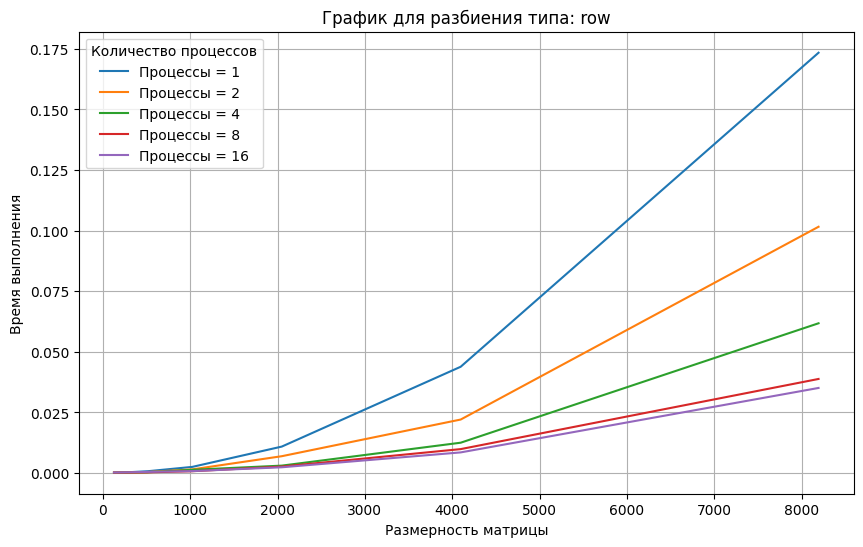

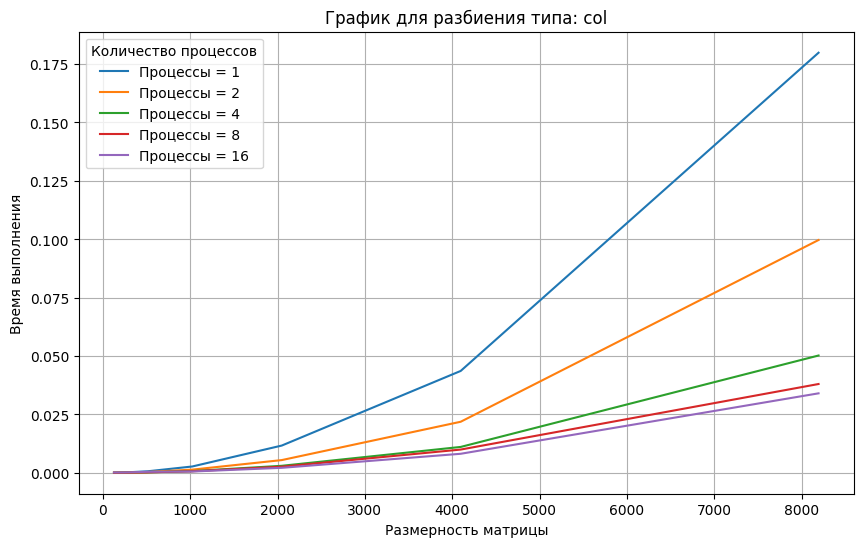

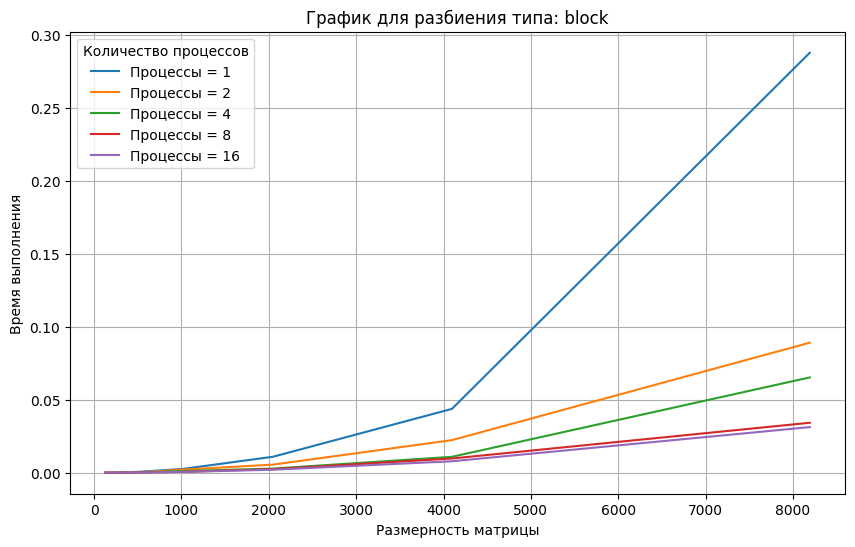

In [ ]:
# Цикл для создания графиков для каждого типа разбиения
for partition_type in results_partitioning['Partitioning'].unique():
    filtered_data = results_partitioning[results_partitioning['Partitioning'] == partition_type]

    processes_list = filtered_data['Processes'].unique()

    plt.figure(figsize=(10, 6))
    for num_procs in processes_list:
        subset = filtered_data[filtered_data['Processes'] == num_procs]
        plt.plot(subset['Size'], subset['Time'], label=f'Процессы = {num_procs}')

    plt.legend(title='Количество процессов')
    plt.title(f'График для разбиения типа: {partition_type}')
    plt.xlabel('Размерность матрицы')
    plt.ylabel('Время выполнения')
    plt.grid(True)
    plt.show()


**Зависимость времени от числа процессов**

**Общая тенденция:**  
Для маленьких матриц (например, 128) увеличение числа процессов не всегда приводит к уменьшению времени. Часто при переходе от 1 к 2 процессам время снижается, но при дальнейшем росте числа процессов оно может стабилизироваться или даже слегка увеличиться из-за коммуникационных накладных расходов. Например, для `block` при Size=128 время 1 процесс: 0.000040 c; 2 процесса: 0.000031 c (быстрее), но уже при 4 процессах: 0.000041 c, что почти возвращает время к исходному уровню.

Для крупных матриц (8192) картина иная: параллелизация приносит значительный выигрыш. Например, для `block` при Size=8192:  
- 1 процесс: ~0.287558 c  
- 8 процессов: ~0.034236 c  
- 16 процессов: ~0.031262 c

Даже если при очень большом числе процессов выигрыш не строго линейный, время при больших размерностях всё же заметно уменьшается по сравнению с однопроцессорным вариантом.

**Сравнение методов (по времени):**  
- При мелких размерах отличие между методами не столь велико, все они упираются в накладные расходы.  
- При больших размерах (`block`, `col`, `row`) все демонстрируют улучшение с ростом числа процессов, но `block` часто показывает более равномерное снижение времени при увеличении числа процессов для крупных матриц.

---

In [ ]:
import math

partition_types = results_partitioning['Partitioning'].unique()
size_list = results_partitioning['Size'].unique()
plots_per_row = 3

#### Среднее время выполнения для размерности матрицы

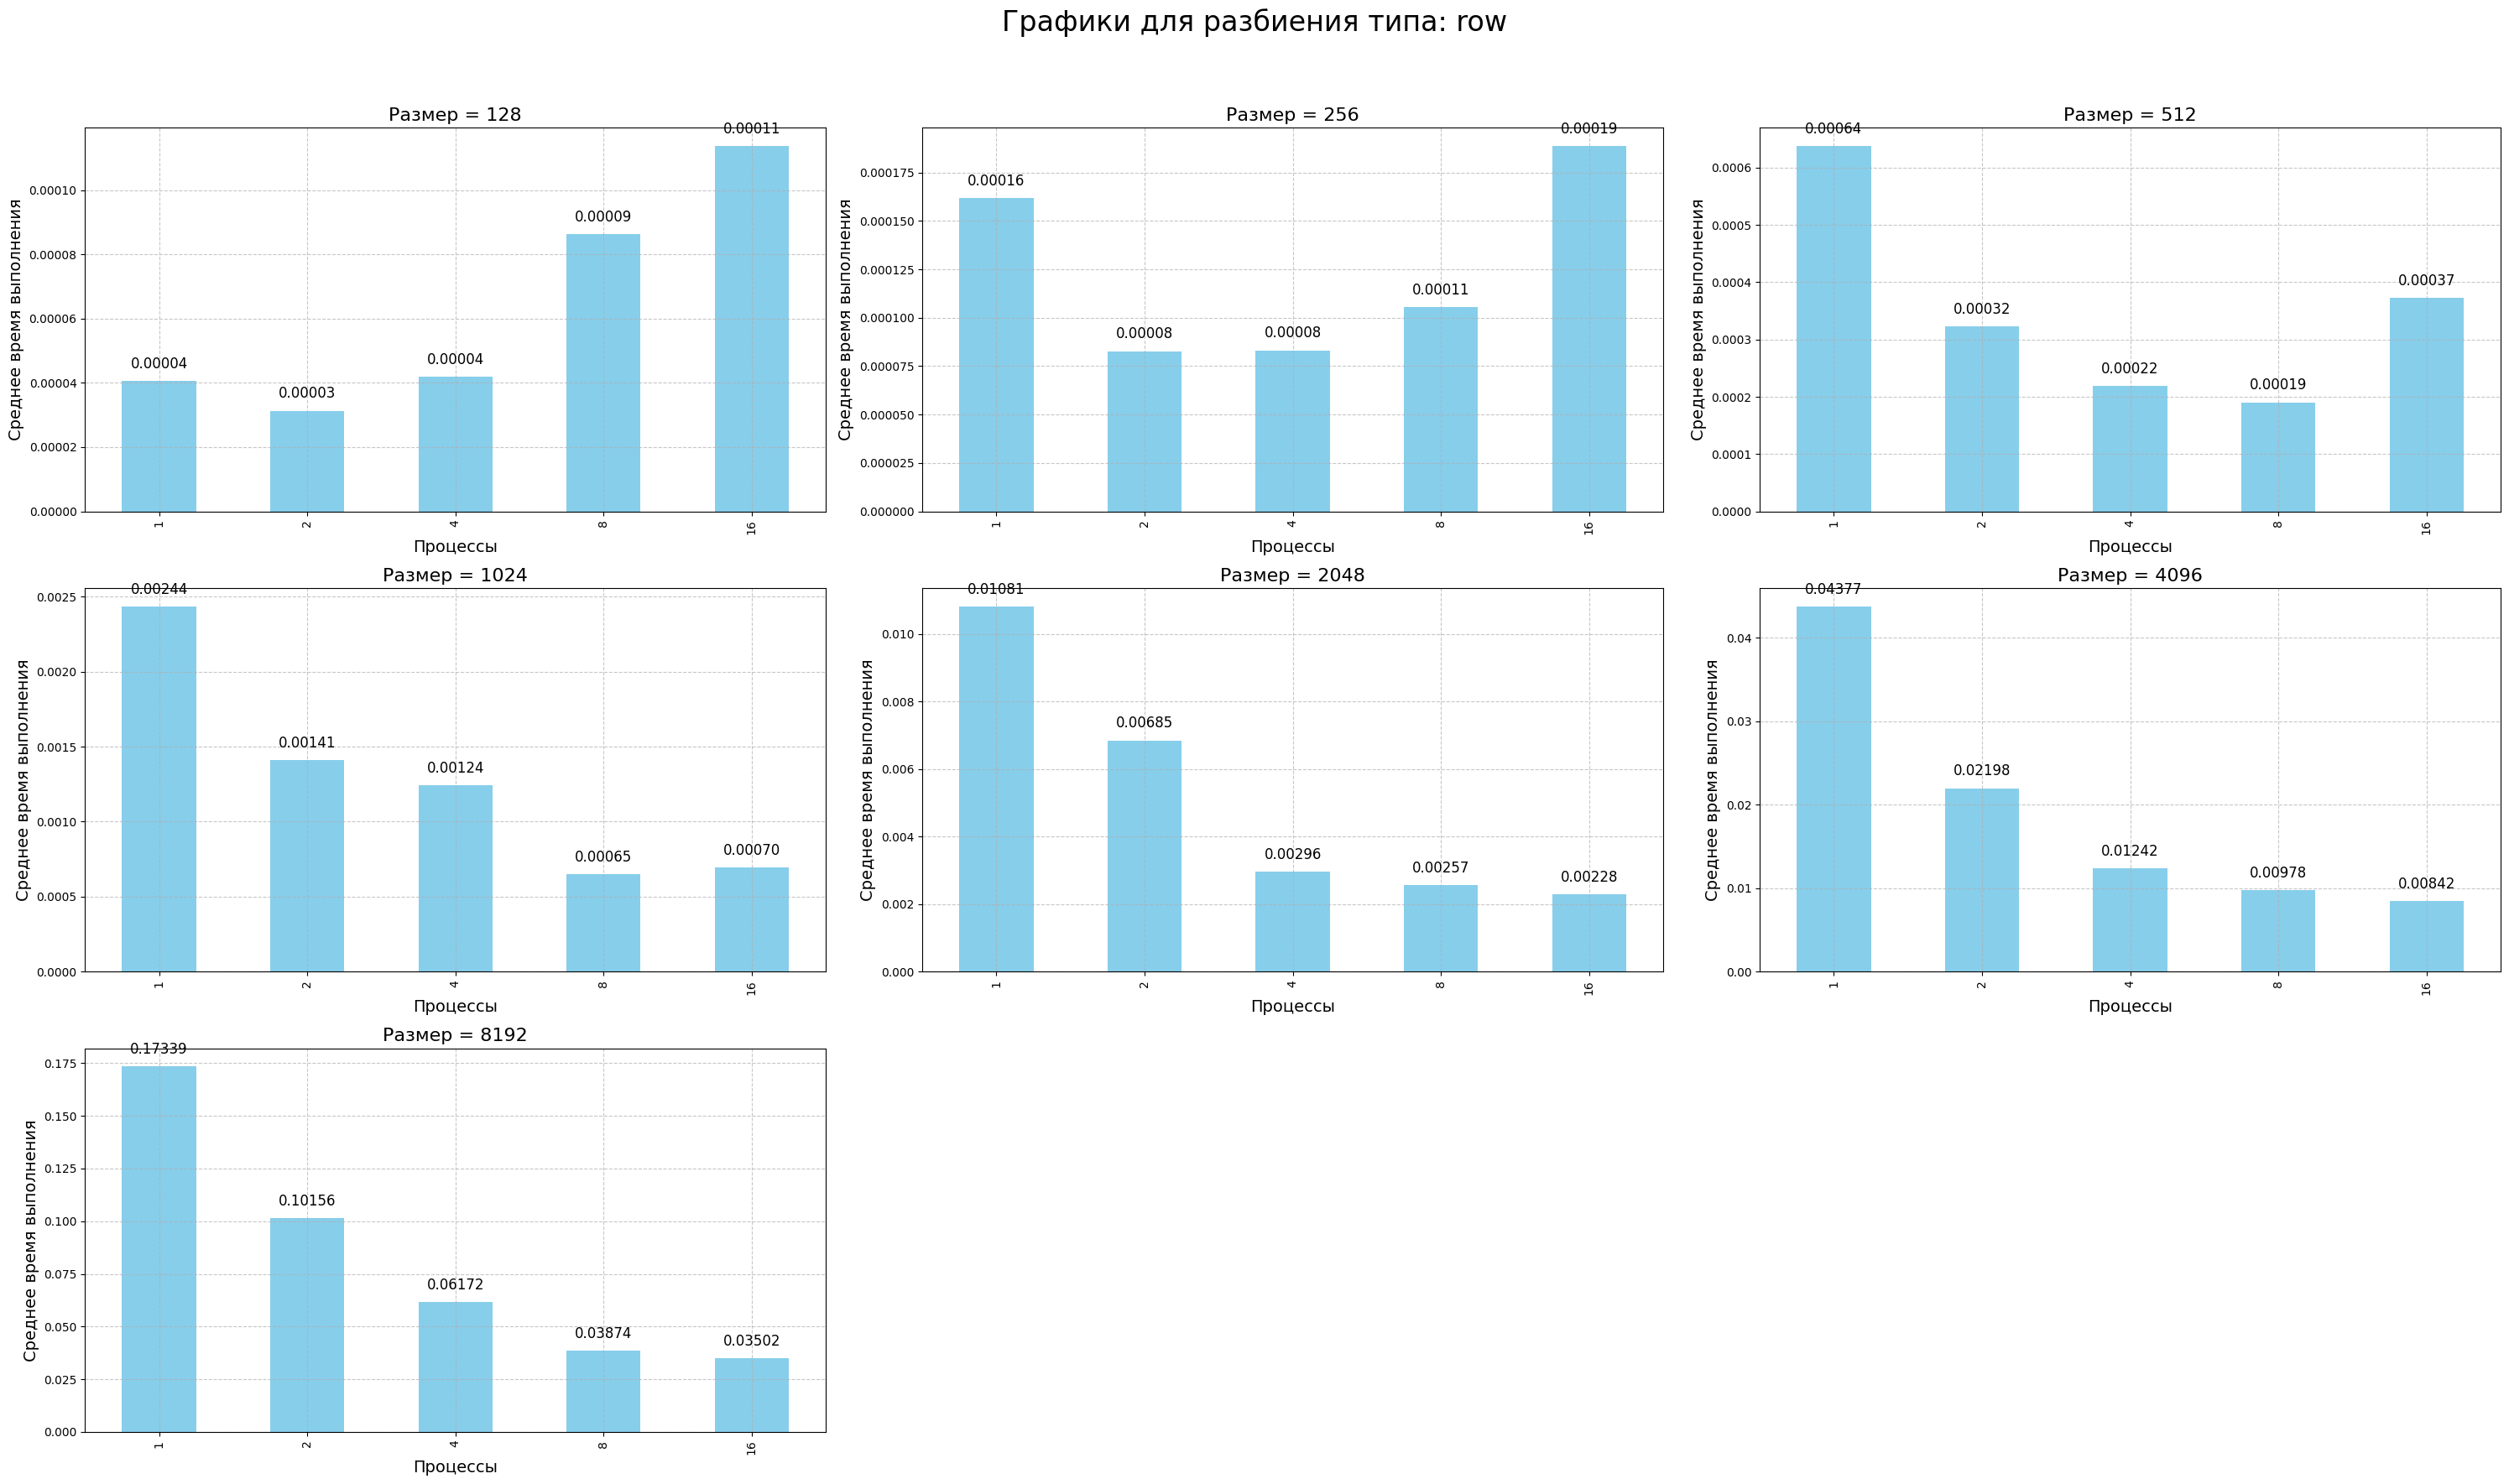

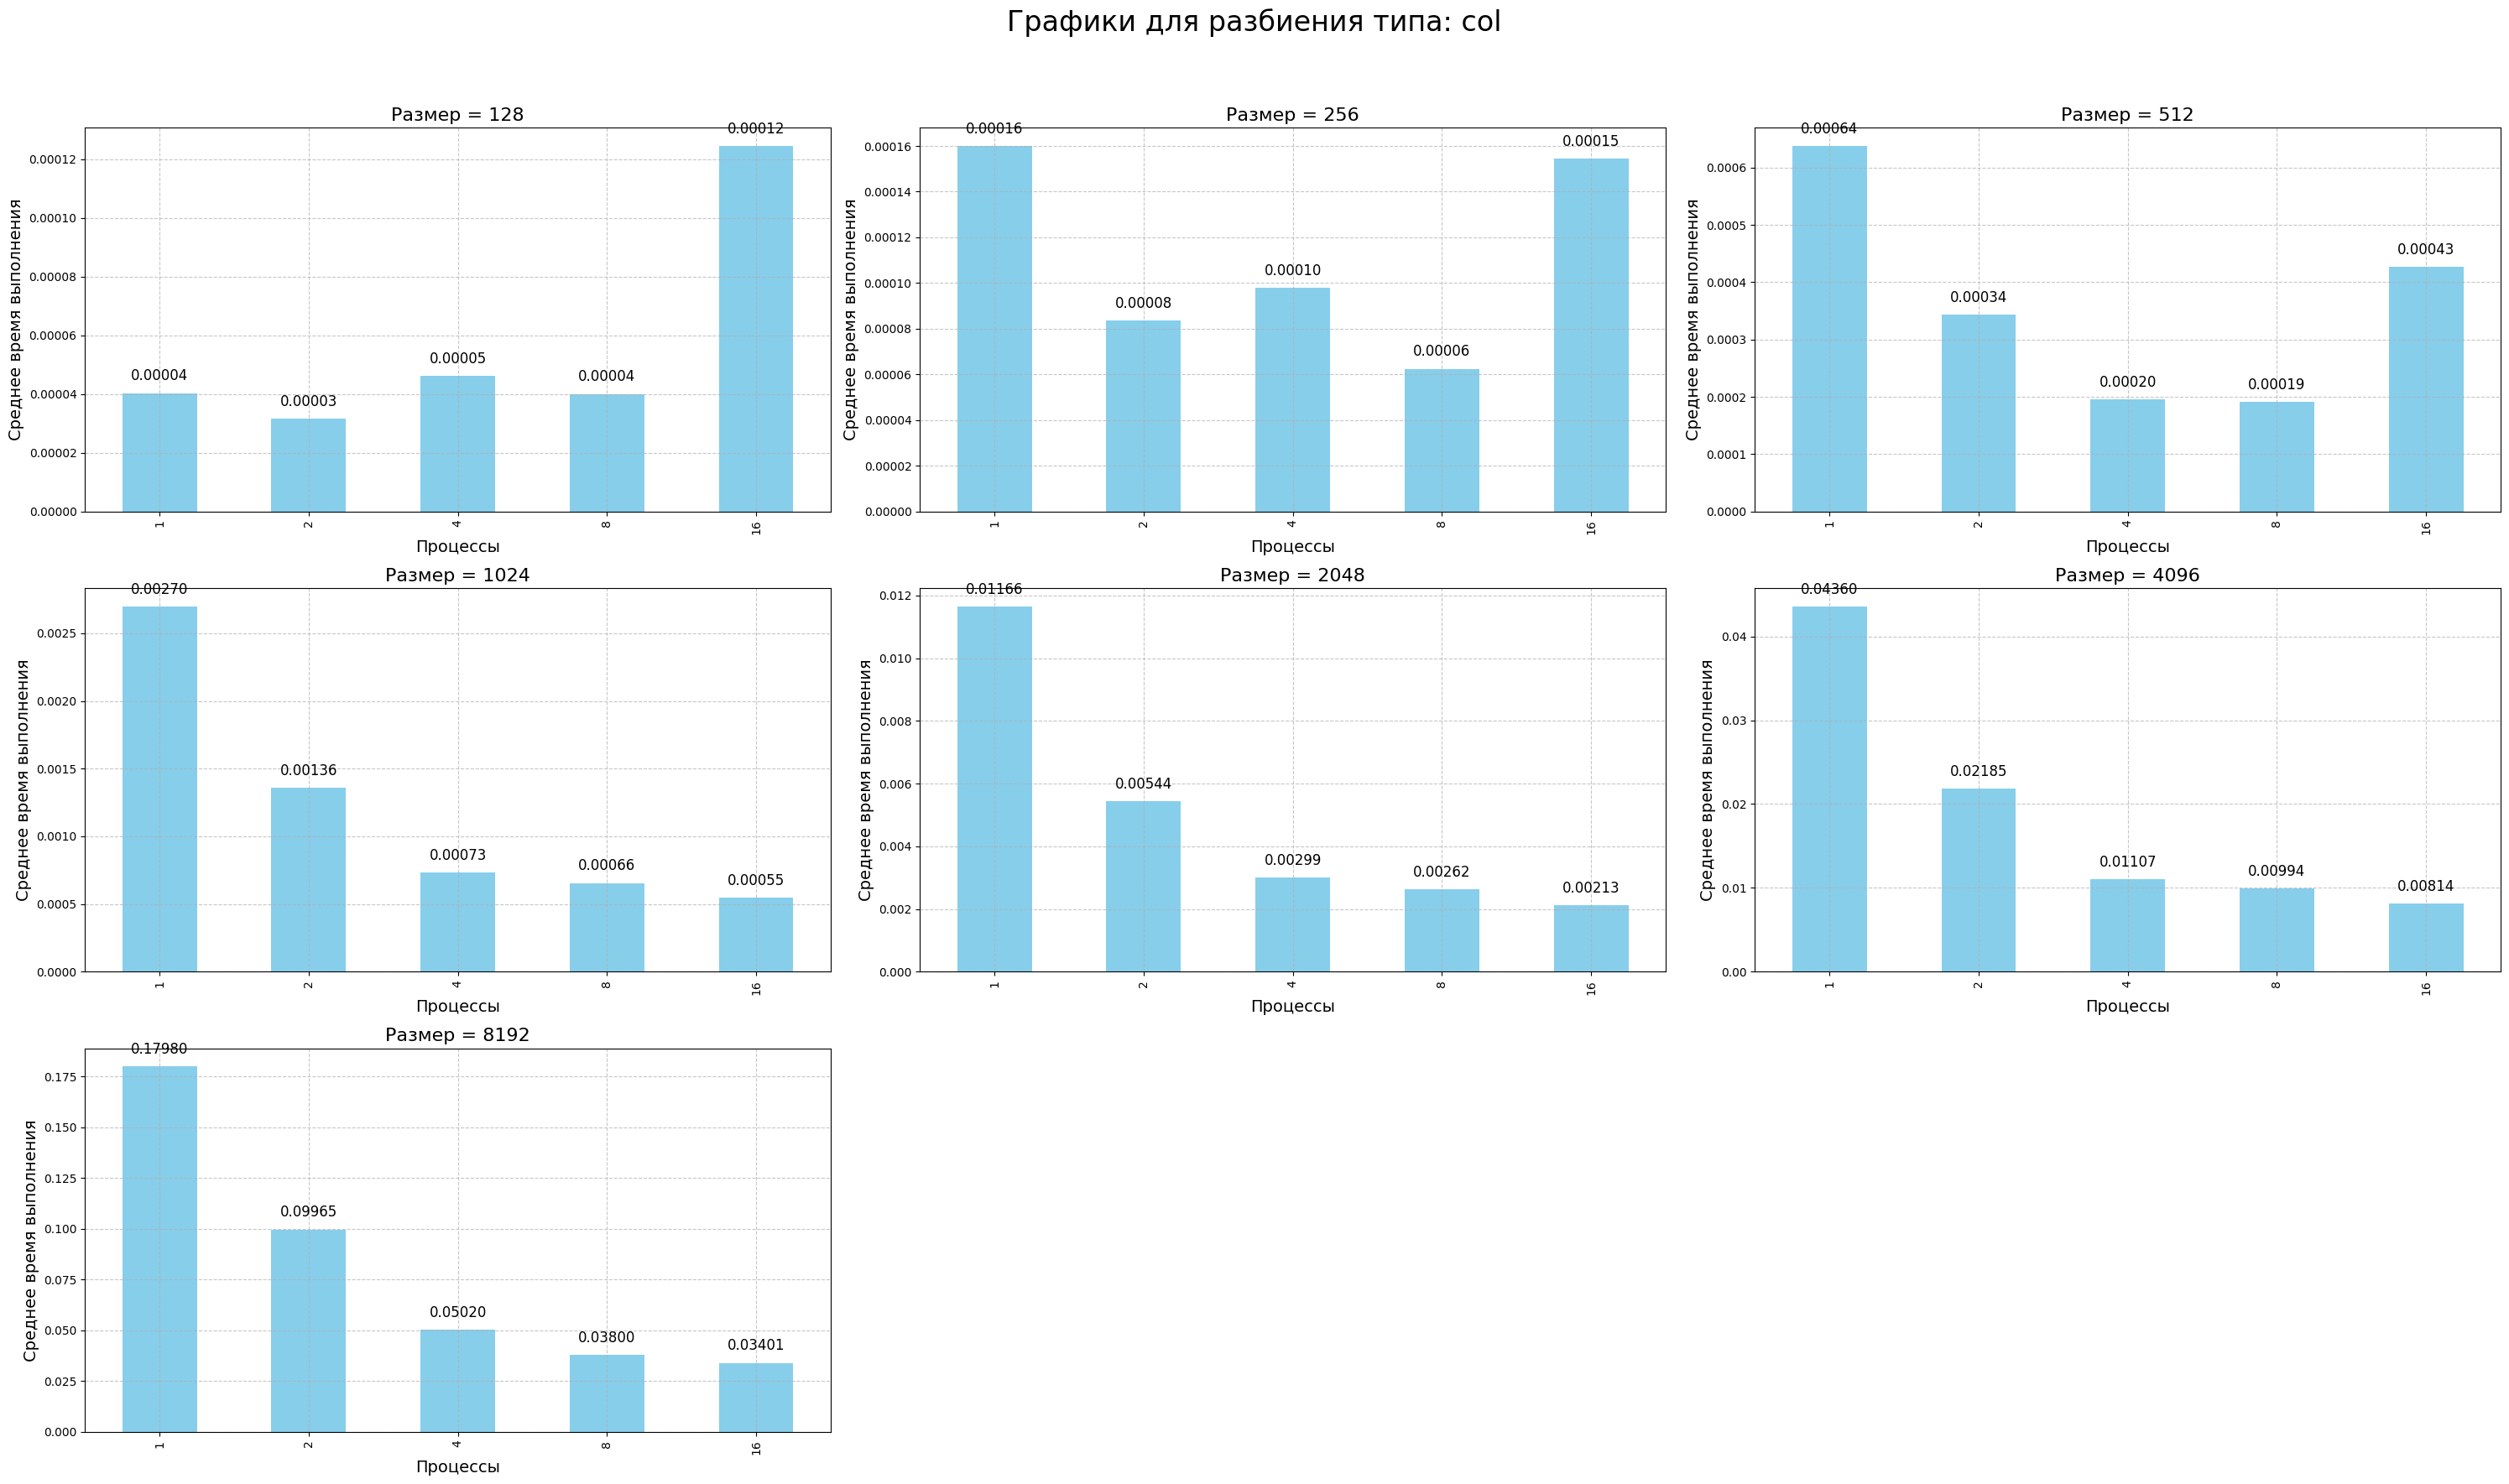

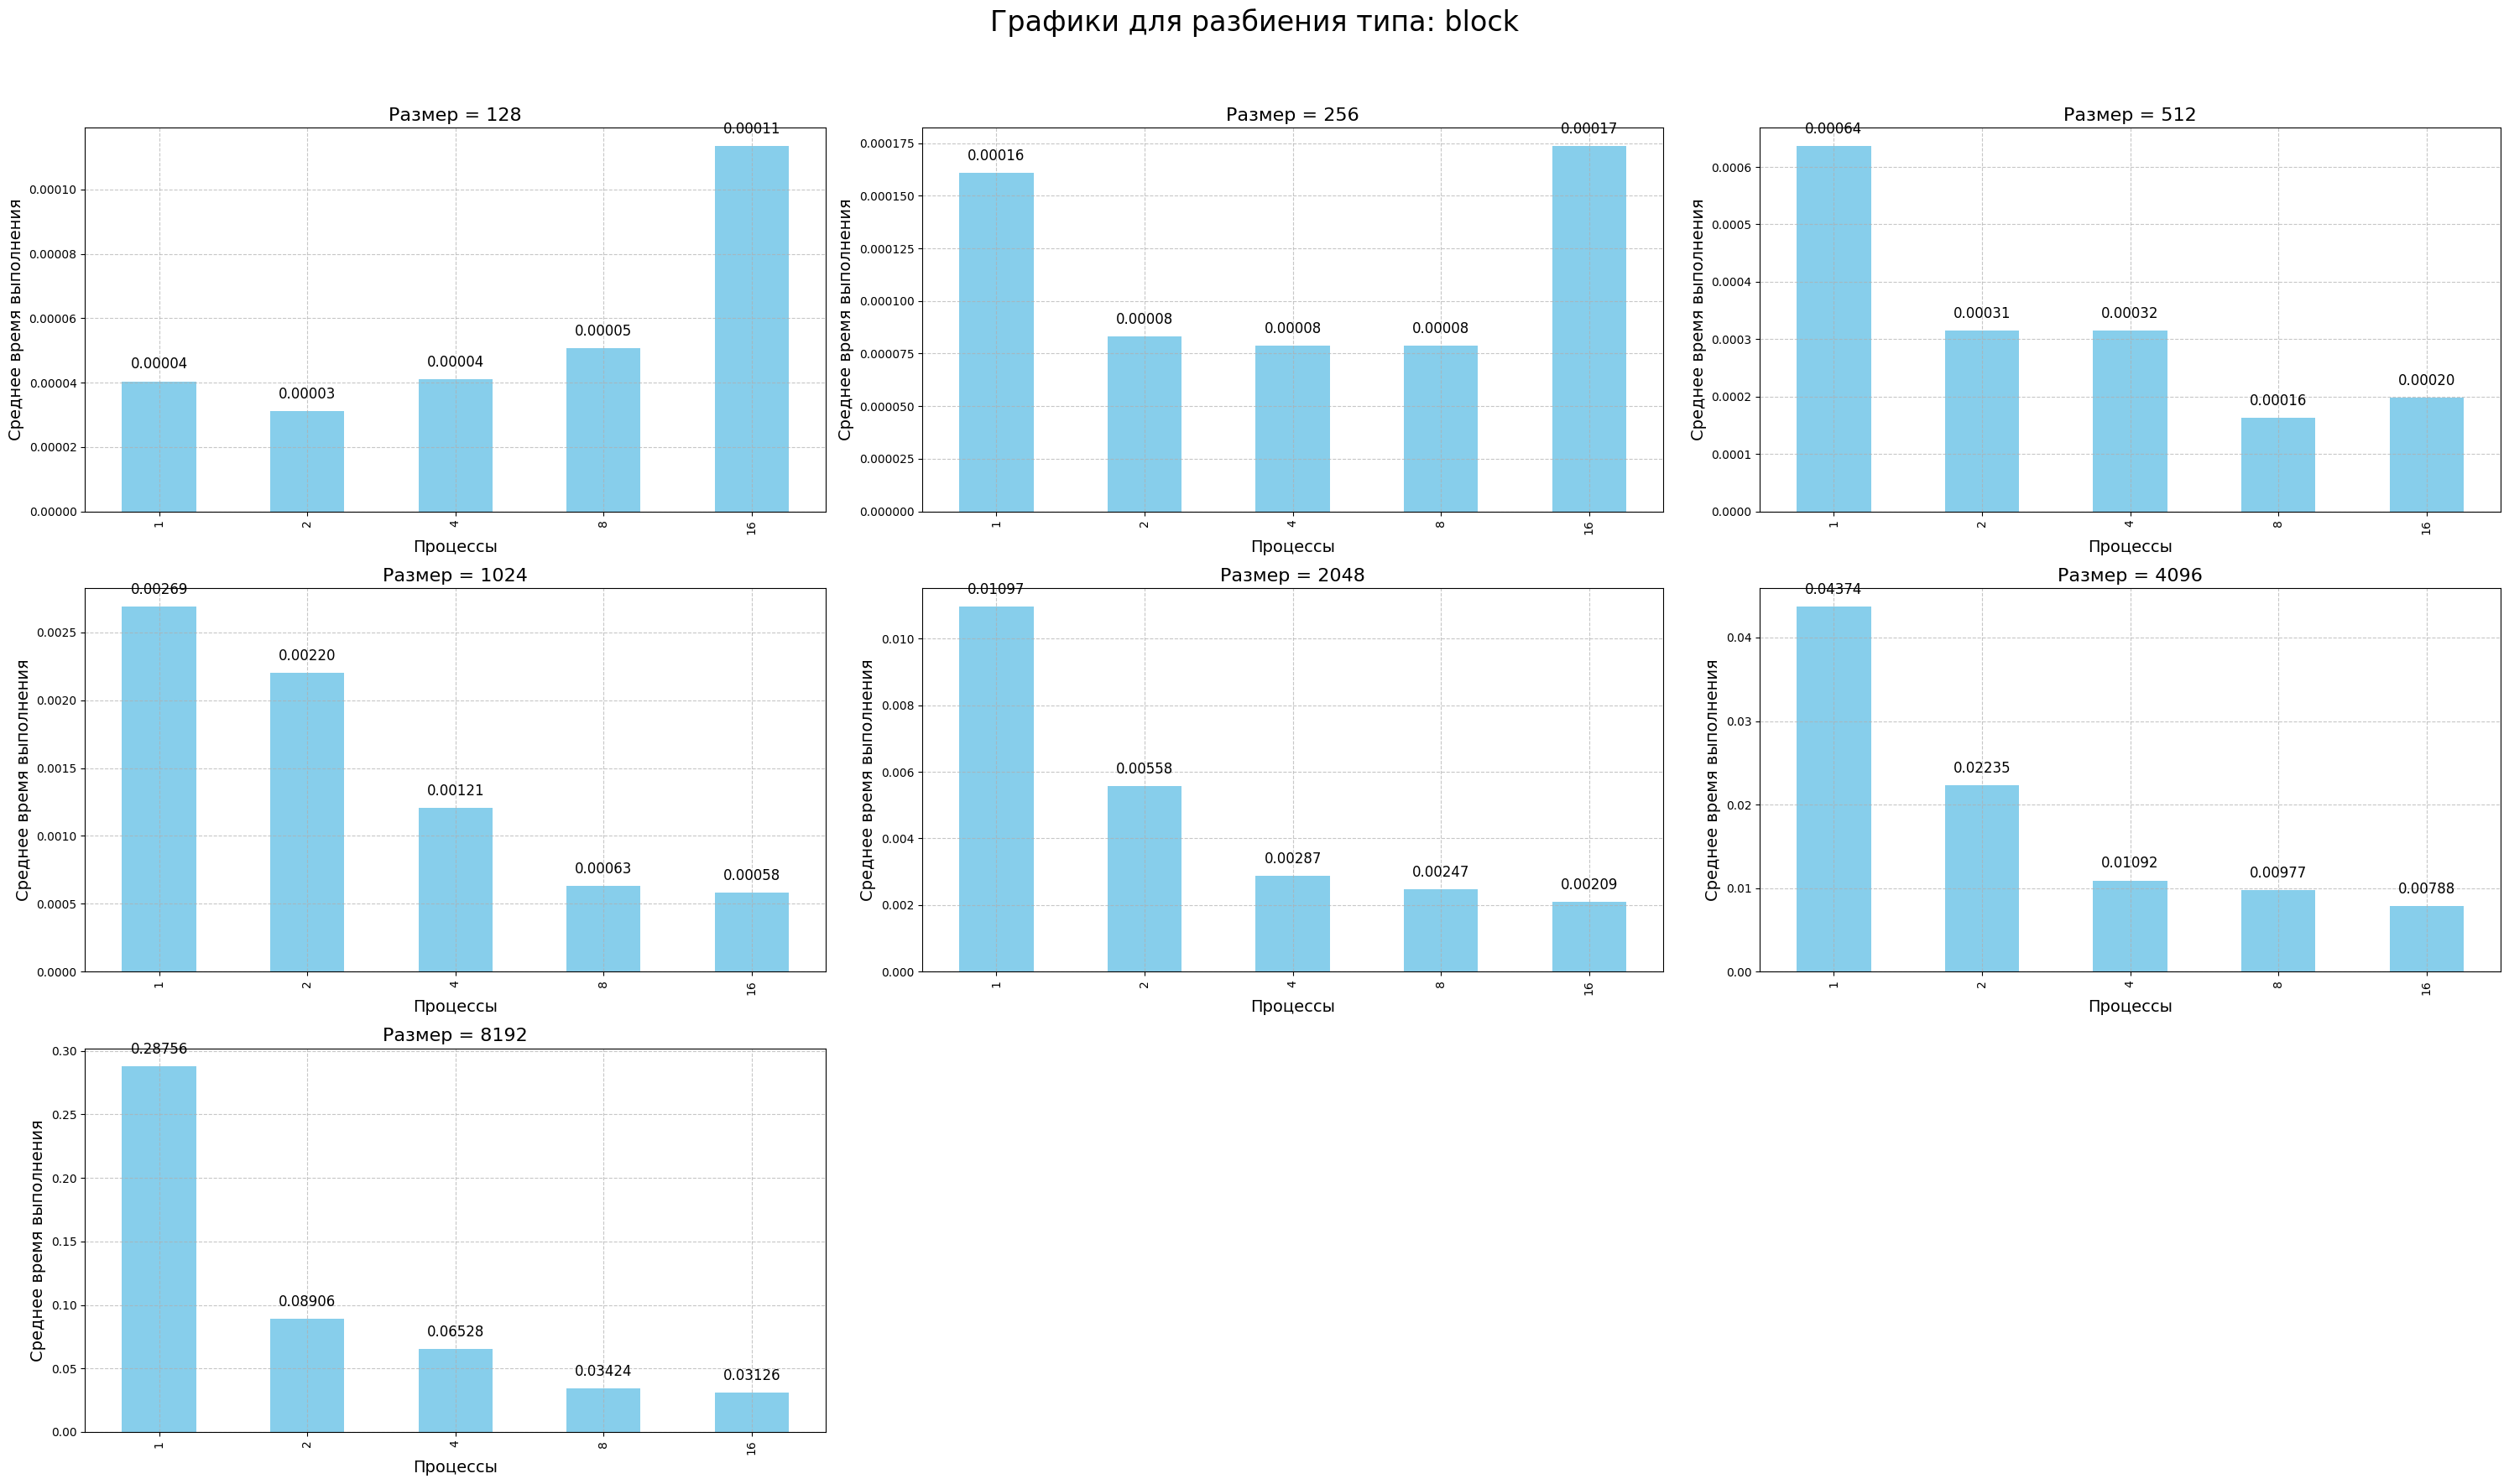

In [ ]:
for partition_type in partition_types:
    filtered_data = results_partitioning[results_partitioning['Partitioning'] == partition_type]

    num_rows = math.ceil(len(size_list) / plots_per_row)
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 10, num_rows * 6))
    fig.suptitle(f'Графики для разбиения типа: {partition_type}', fontsize=24)

    axes = axes.flatten()

    for i, size in enumerate(size_list):
        subset = filtered_data[filtered_data['Size'] == size]

        mean_times = subset.groupby('Processes')['Time'].mean()

        ax = axes[i]
        mean_times.plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title(f'Размер = {size}', fontsize=16)
        ax.set_xlabel('Процессы', fontsize=14)
        ax.set_ylabel('Среднее время выполнения', fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)

        for p in ax.patches:
            ax.annotate(f"{p.get_height():.5f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom',
                        xytext=(0, 8),
                        textcoords='offset points',
                        fontsize=12)

    for j in range(len(size_list), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


**Зависимость времени выполнения при разных размерностях матрицы**

При фиксированном числе процессов время растёт с увеличением размерности матрицы, что естественно, так как объём вычислений увеличивается. Например, для `block` при 1 процессе:  
- N=128: 0.000040 c  
- N=8192: 0.287558 c

Аналогично, при 1 процессе для `col` или `row` рост времени с увеличением размерности также очевиден.

Параллелизация помогает «сдерживать» рост времени. Например, при 8 или 16 процессах время для больших матриц существенно меньше, чем при 1 процессе. На крупных задачах параллельные методы выигрывают особенно заметно.

---

#### График зависимости ускорения от количества процессоров

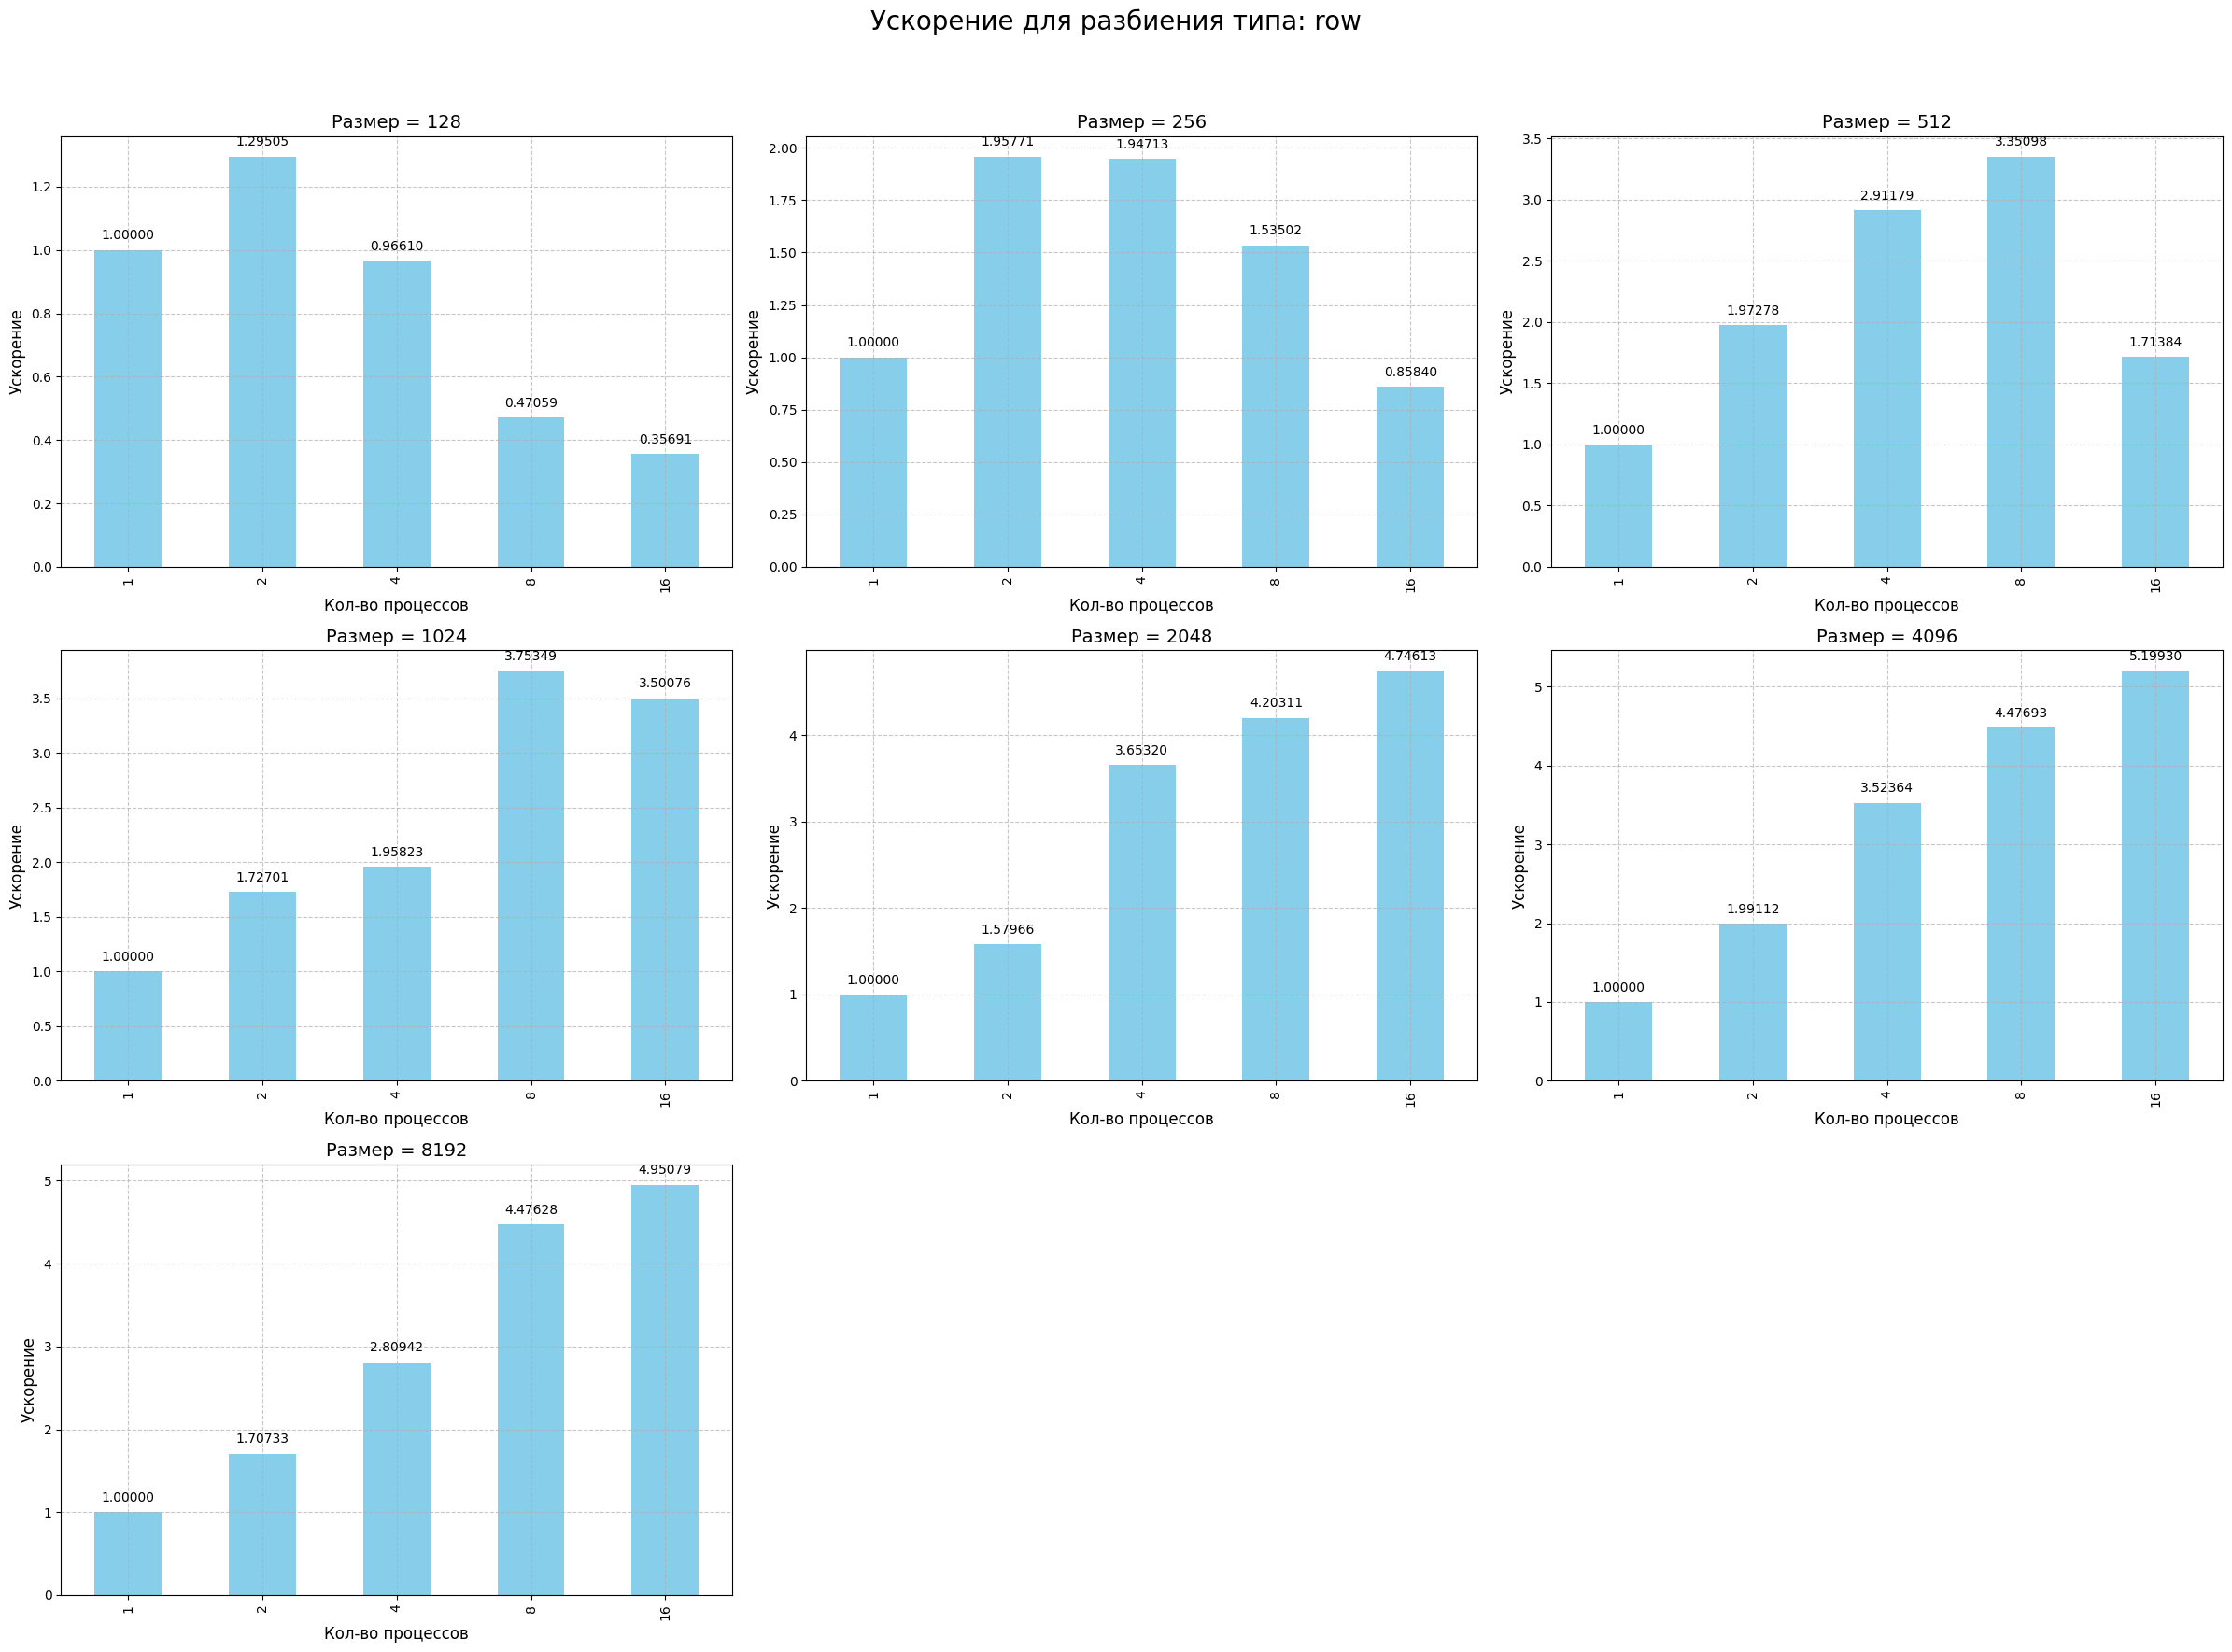

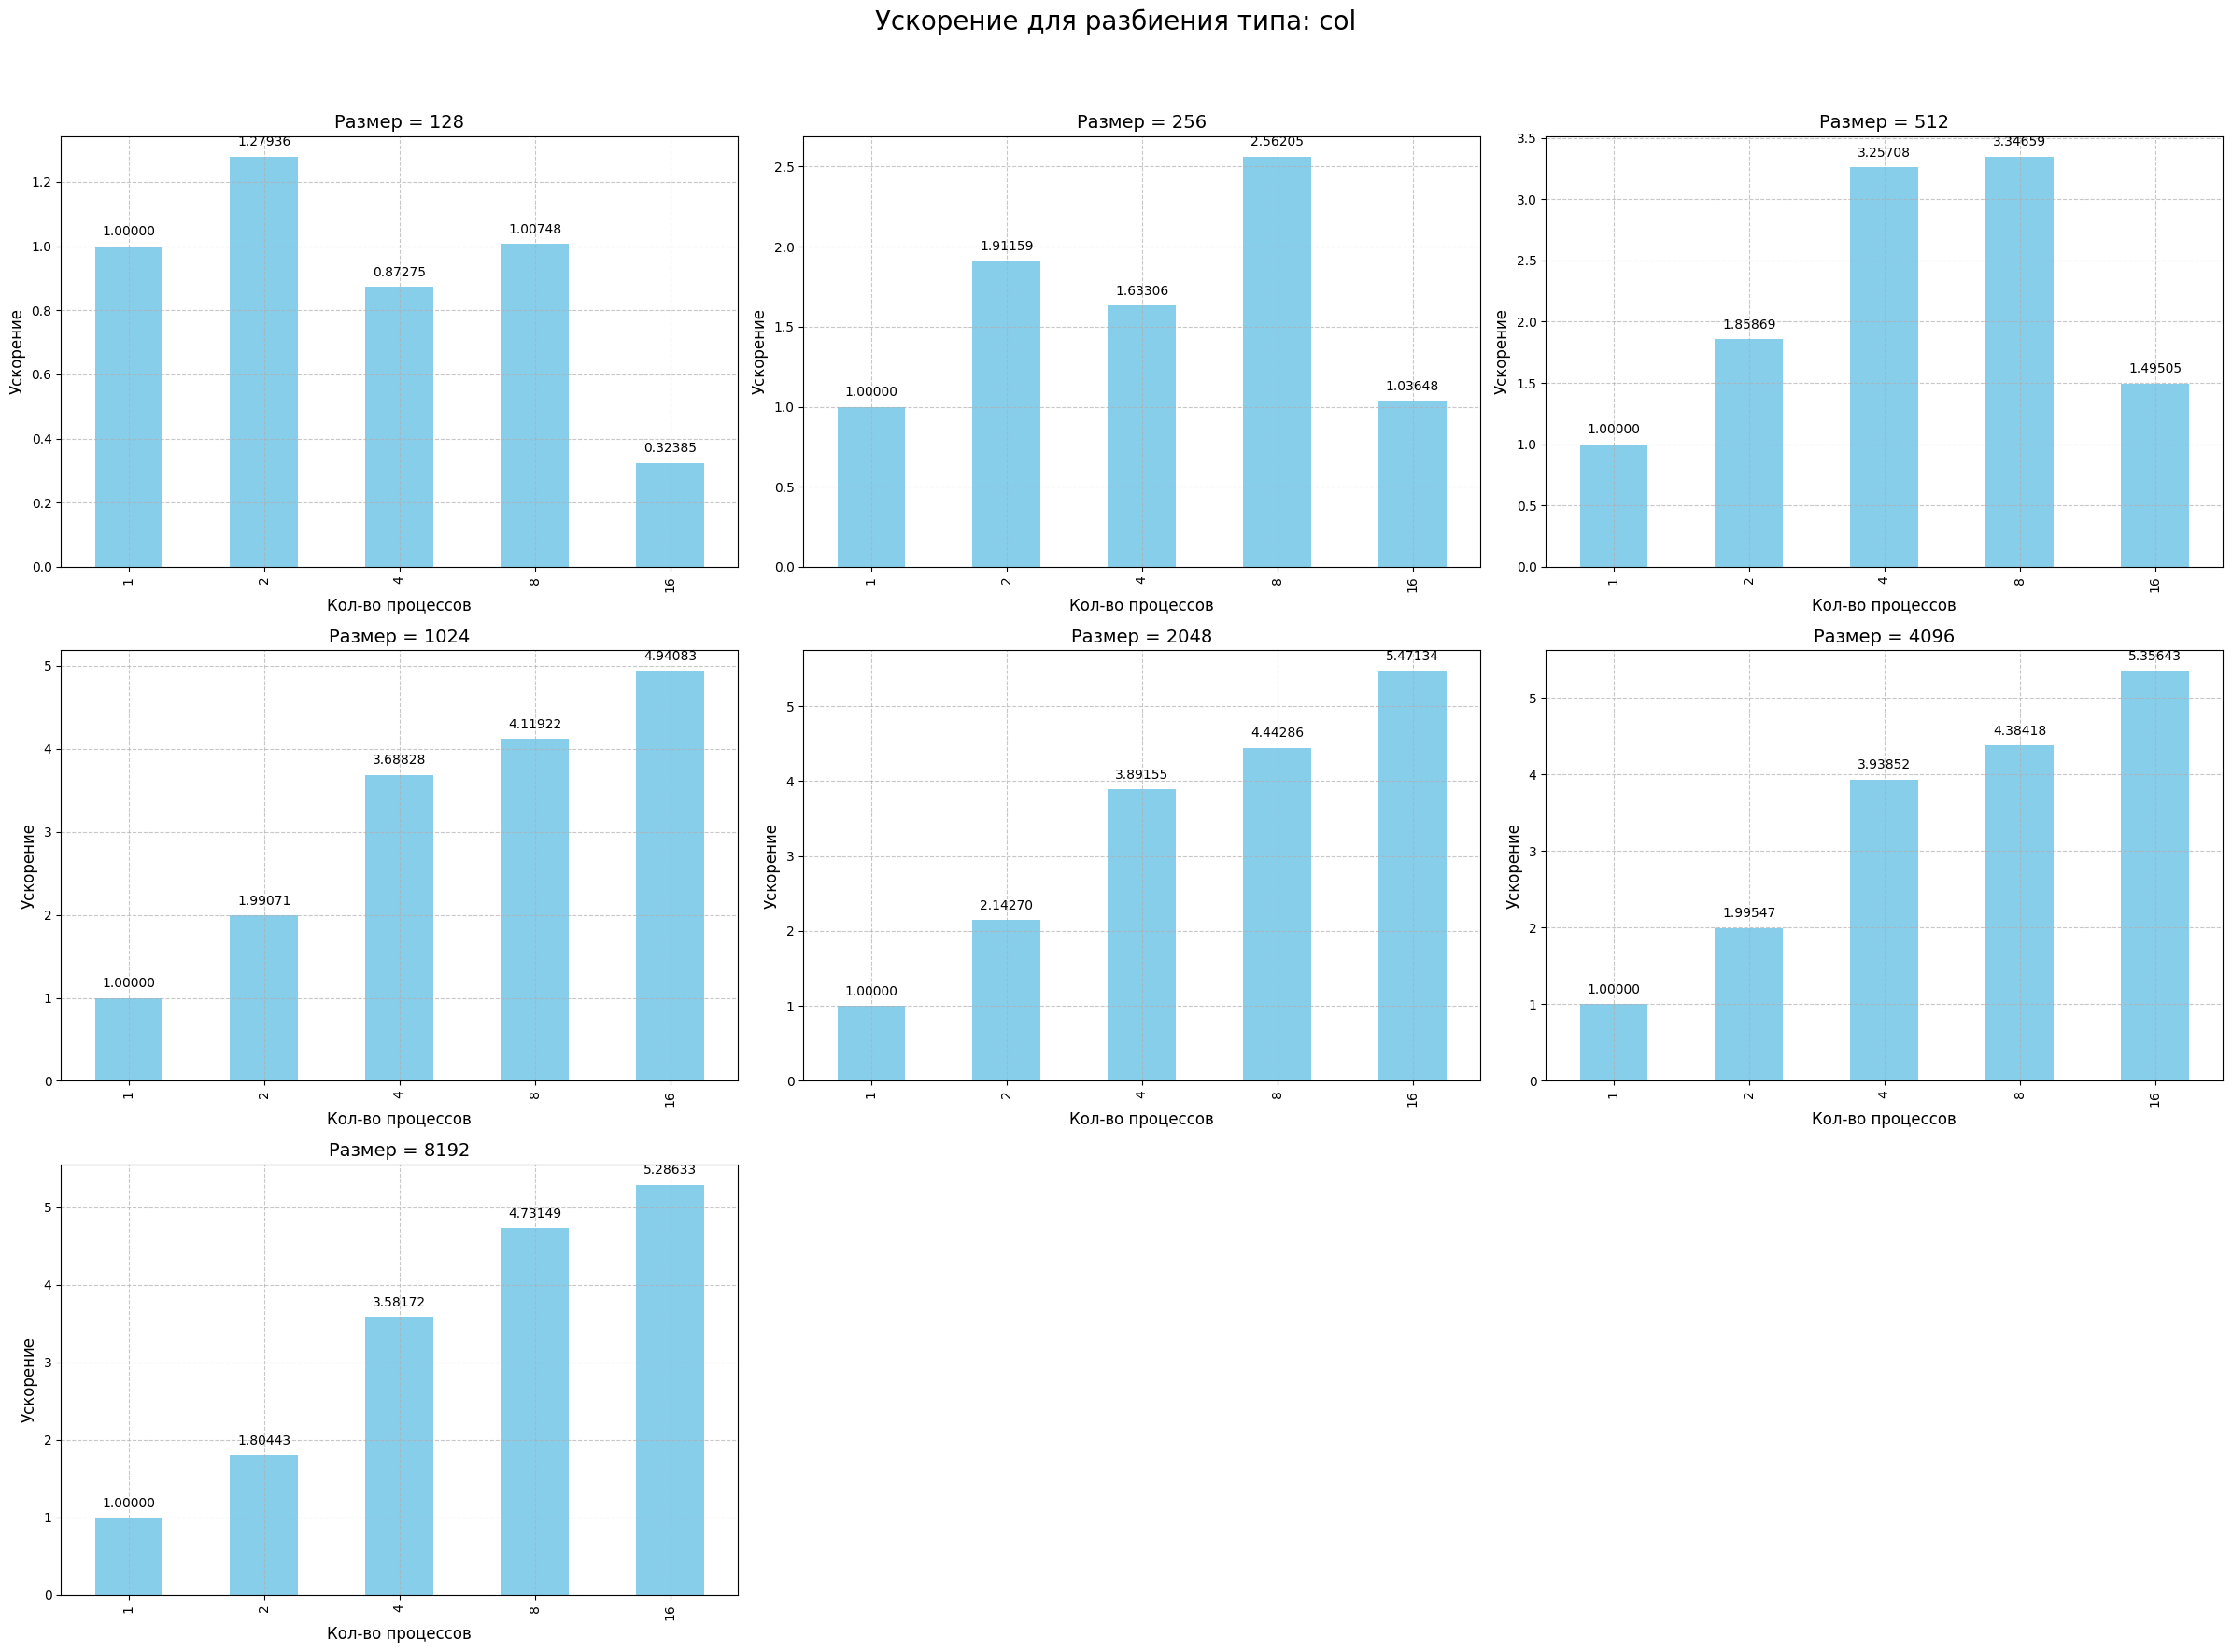

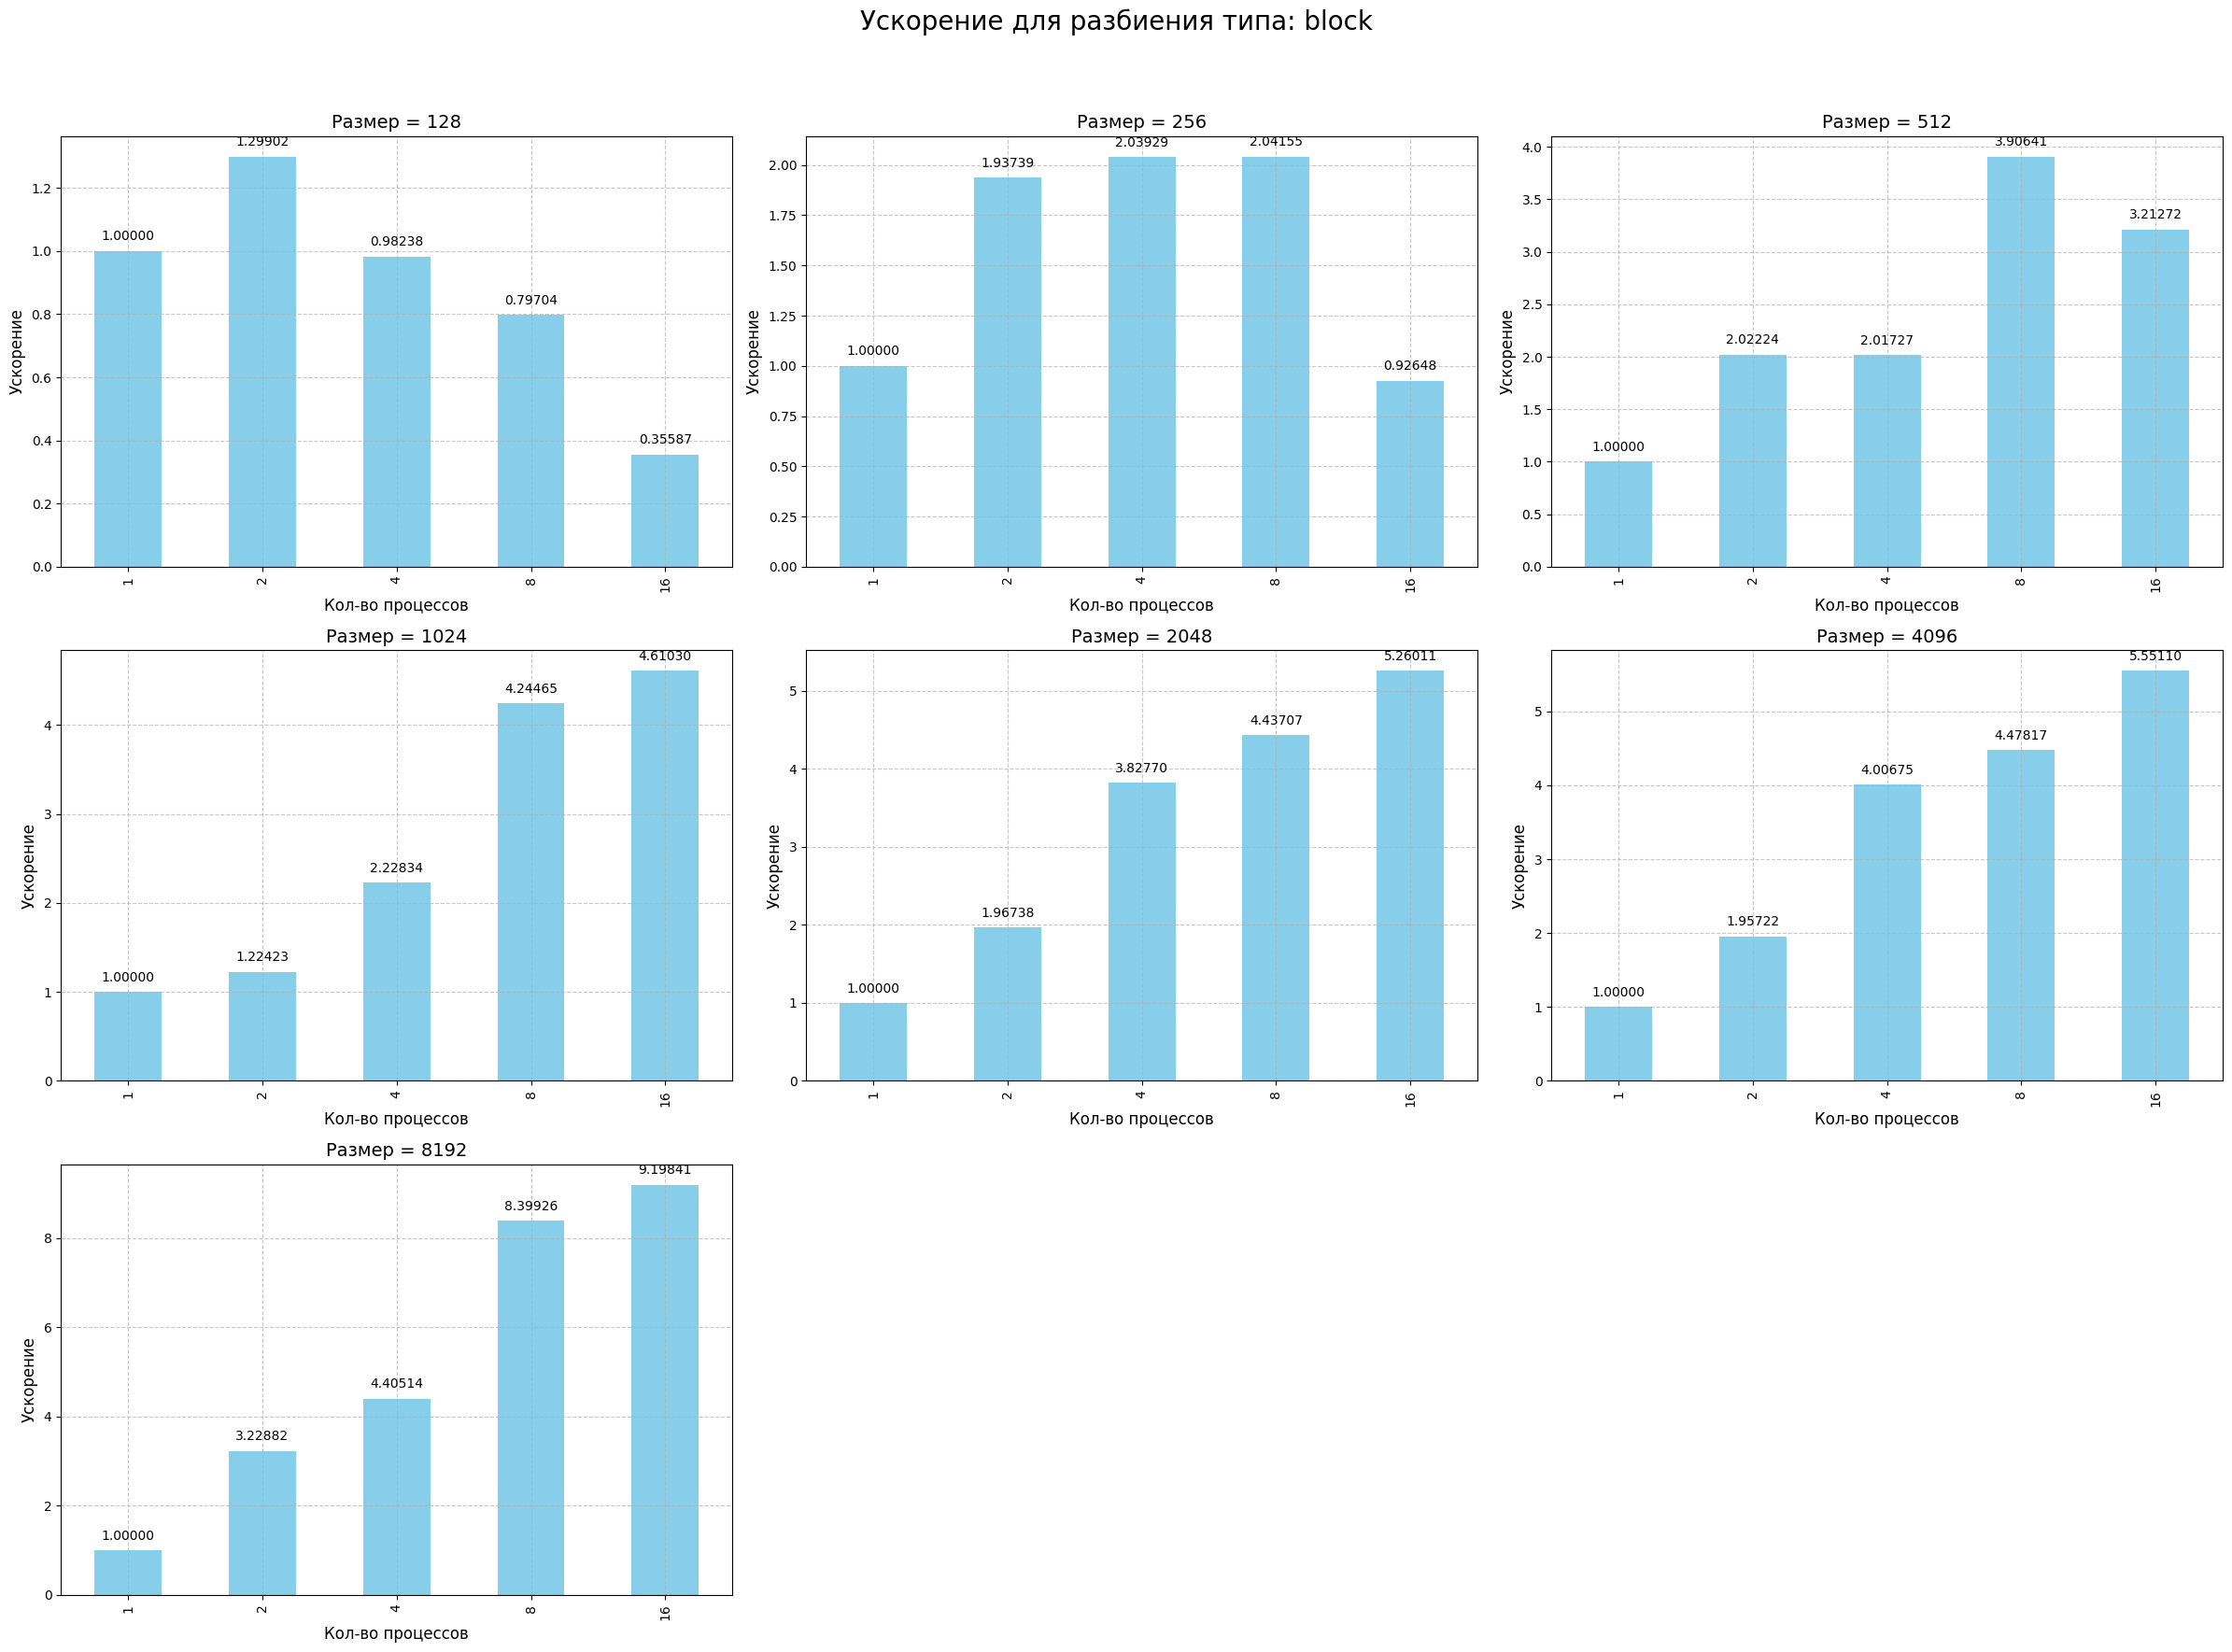

In [ ]:
for partition_type in partition_types:
    filtered_data = results_partitioning[results_partitioning['Partitioning'] == partition_type]

    num_rows = math.ceil(len(size_list) / plots_per_row)
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 8, num_rows * 6))
    fig.suptitle(f'Ускорение для разбиения типа: {partition_type}', fontsize=20)

    axes = axes.flatten()

    for i, size in enumerate(size_list):
        subset = filtered_data[filtered_data['Size'] == size]

        mean_acceleration = subset.groupby('Processes')['Acceleration'].mean()

        ax = axes[i]
        mean_acceleration.plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title(f'Размер = {size}', fontsize=14)
        ax.set_xlabel('Кол-во процессов', fontsize=12)
        ax.set_ylabel('Ускорение', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)

        for p in ax.patches:
            ax.annotate(f"{p.get_height():.5f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom',
                        xytext=(0, 6),
                        textcoords='offset points',
                        fontsize=10)

    for j in range(len(size_list), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

**Зависимость ускорения от числа процессов**

Ускорение (Acceleration = T(1)/T(p)) показывает, во сколько раз решение ускорилось по сравнению с последовательным запуском:

- Для небольших матриц (N=128, N=256) ускорение заметно при переходе к 2 процессам, но при дальнейшем увеличении числа процессов часто падает. Это происходит, потому что сама задача слишком мала, и затраты на коммуникацию начинают доминировать.
  
  Например, для `block` при N=128:  
  - 2 процесса: ускорение ~1.299  
  - 8 процессов: ускорение ~0.797 (меньше 1, то есть хуже, чем 1 процесс в теоретическом плане)

- Для больших матриц ускорение растёт значительно. Например, для `block` при N=8192:  
  - 8 процессов: ускорение ~8.399 (превосходит линейный рост!)  
  - 16 процессов: ускорение ~9.198 (очень высокое ускорение)

Аналогично для `col` и `row` при увеличении размерности матрицы и числа процессов ускорение становится ближе к линейному или даже превышает его. Однако `block`-разбиение часто даёт более высокие ускорения на очень больших задачах.

---

#### График зависимости эффективности от количества процессоров

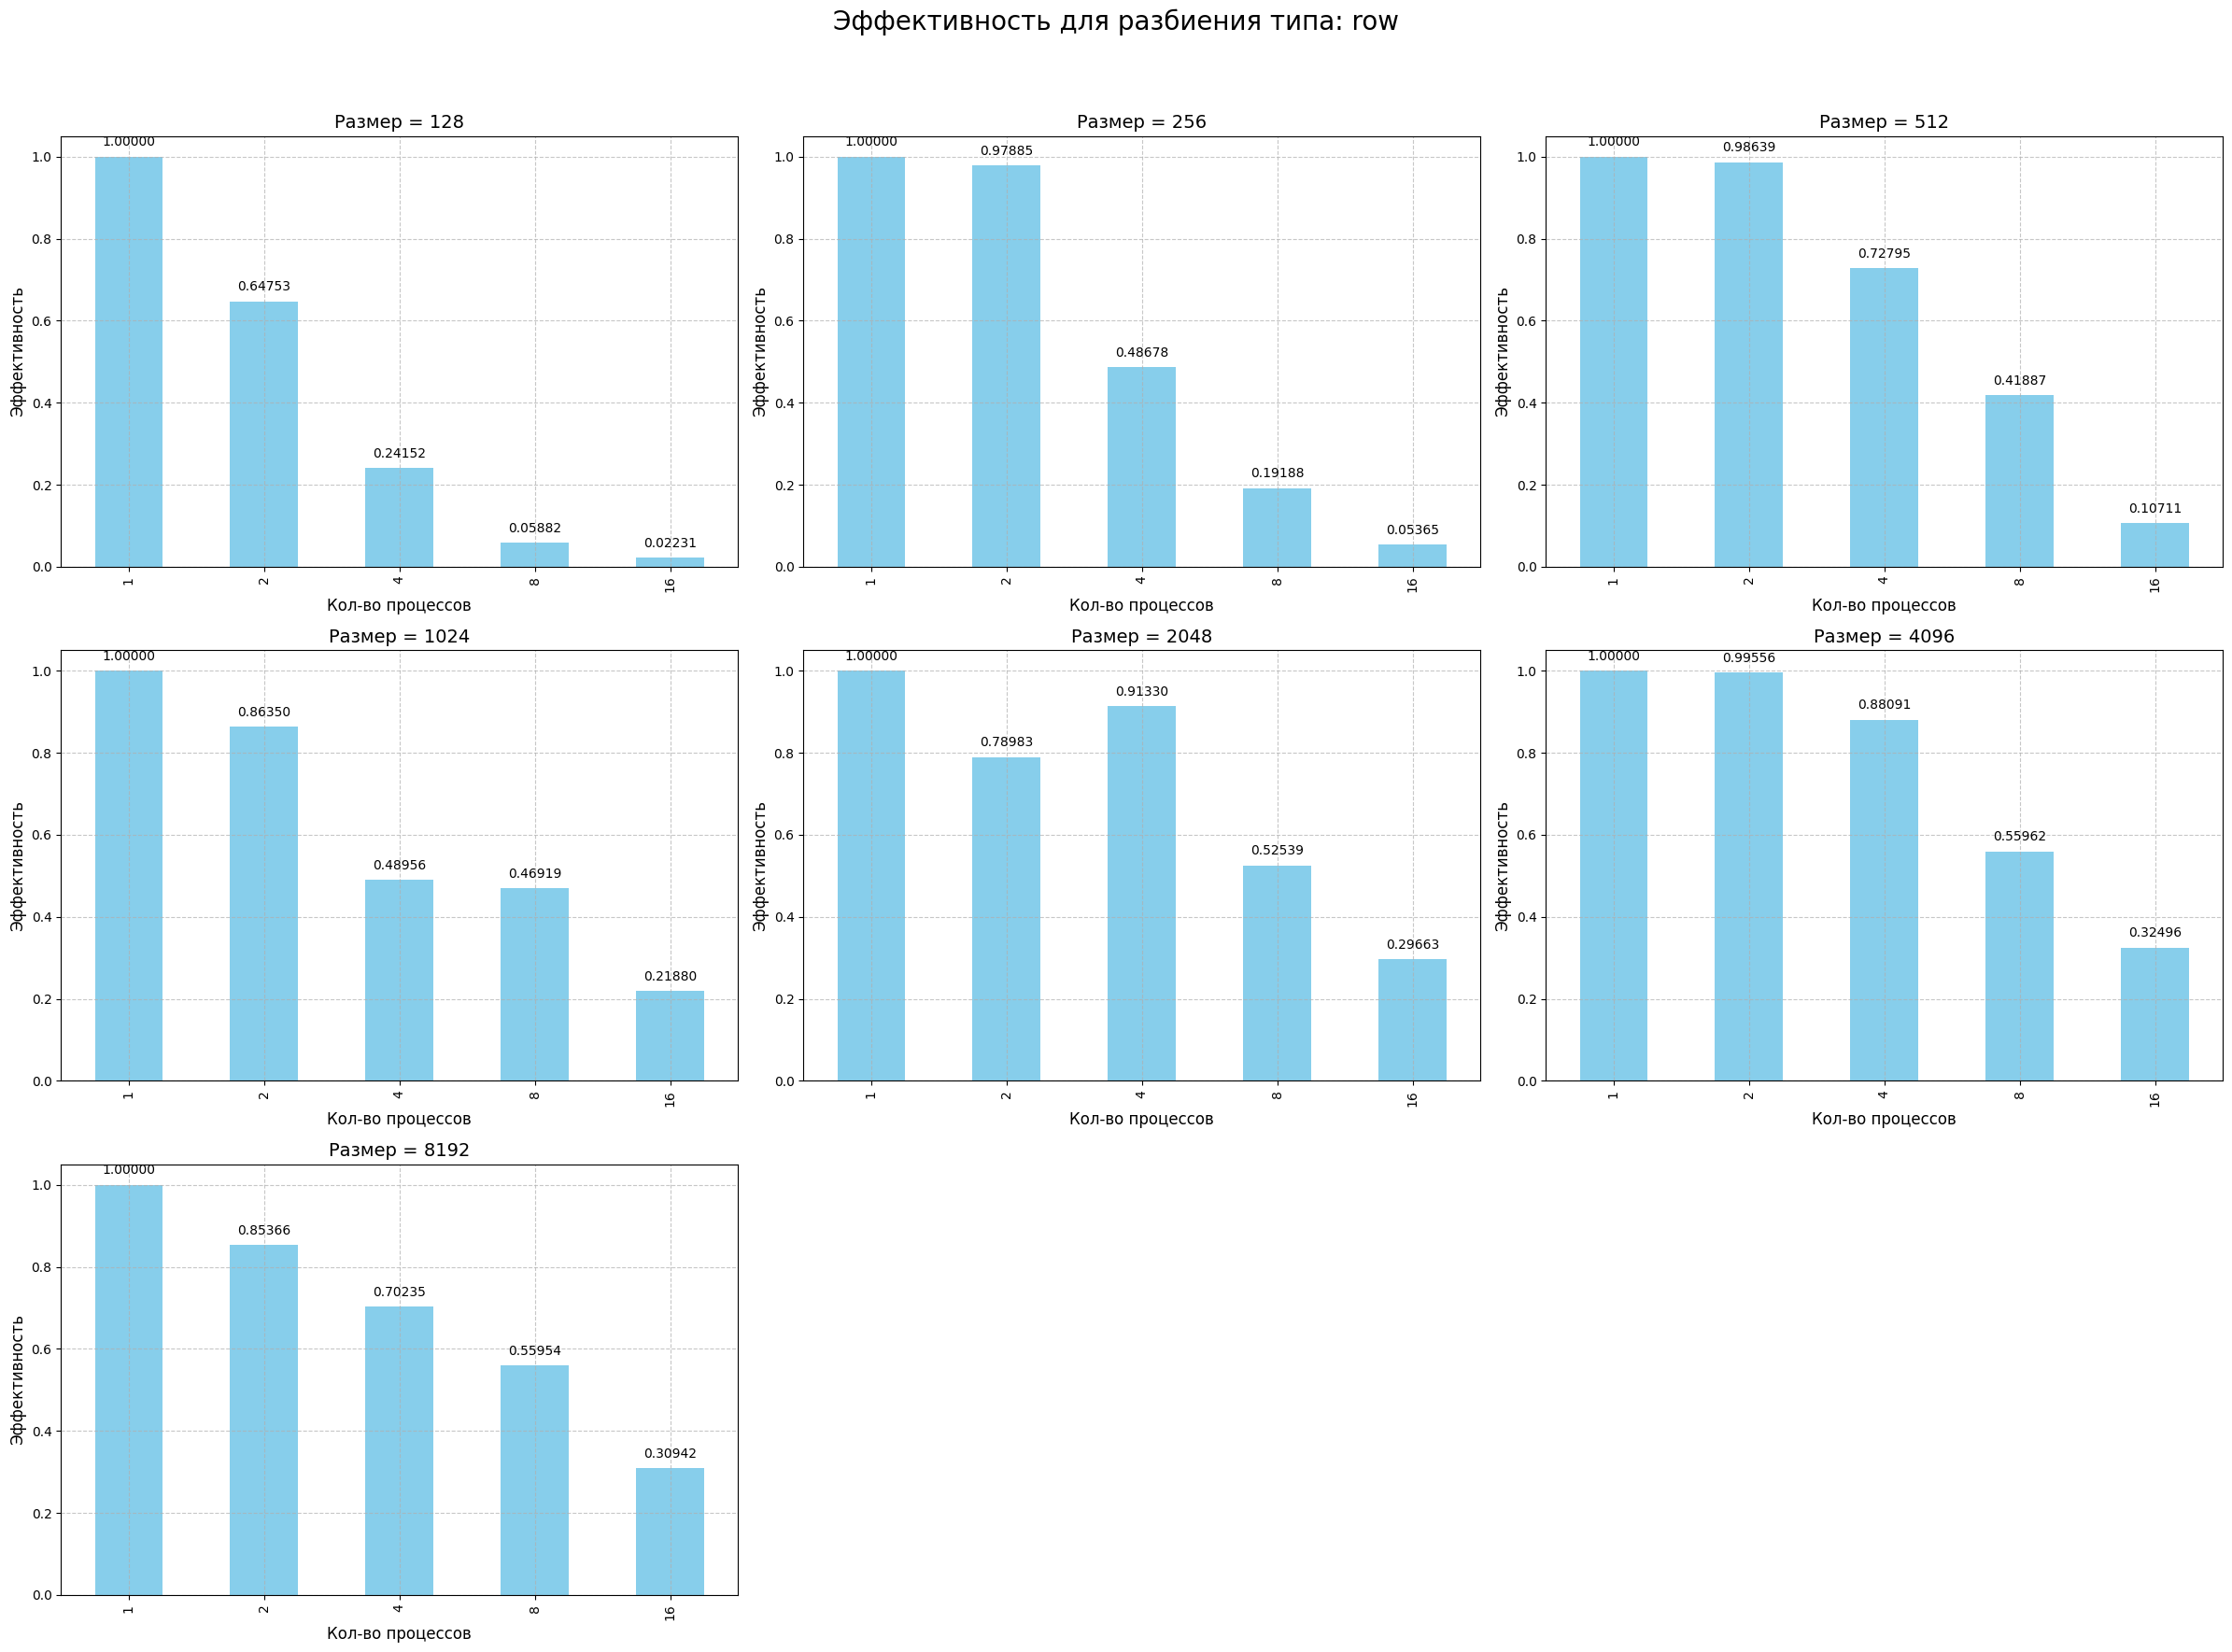

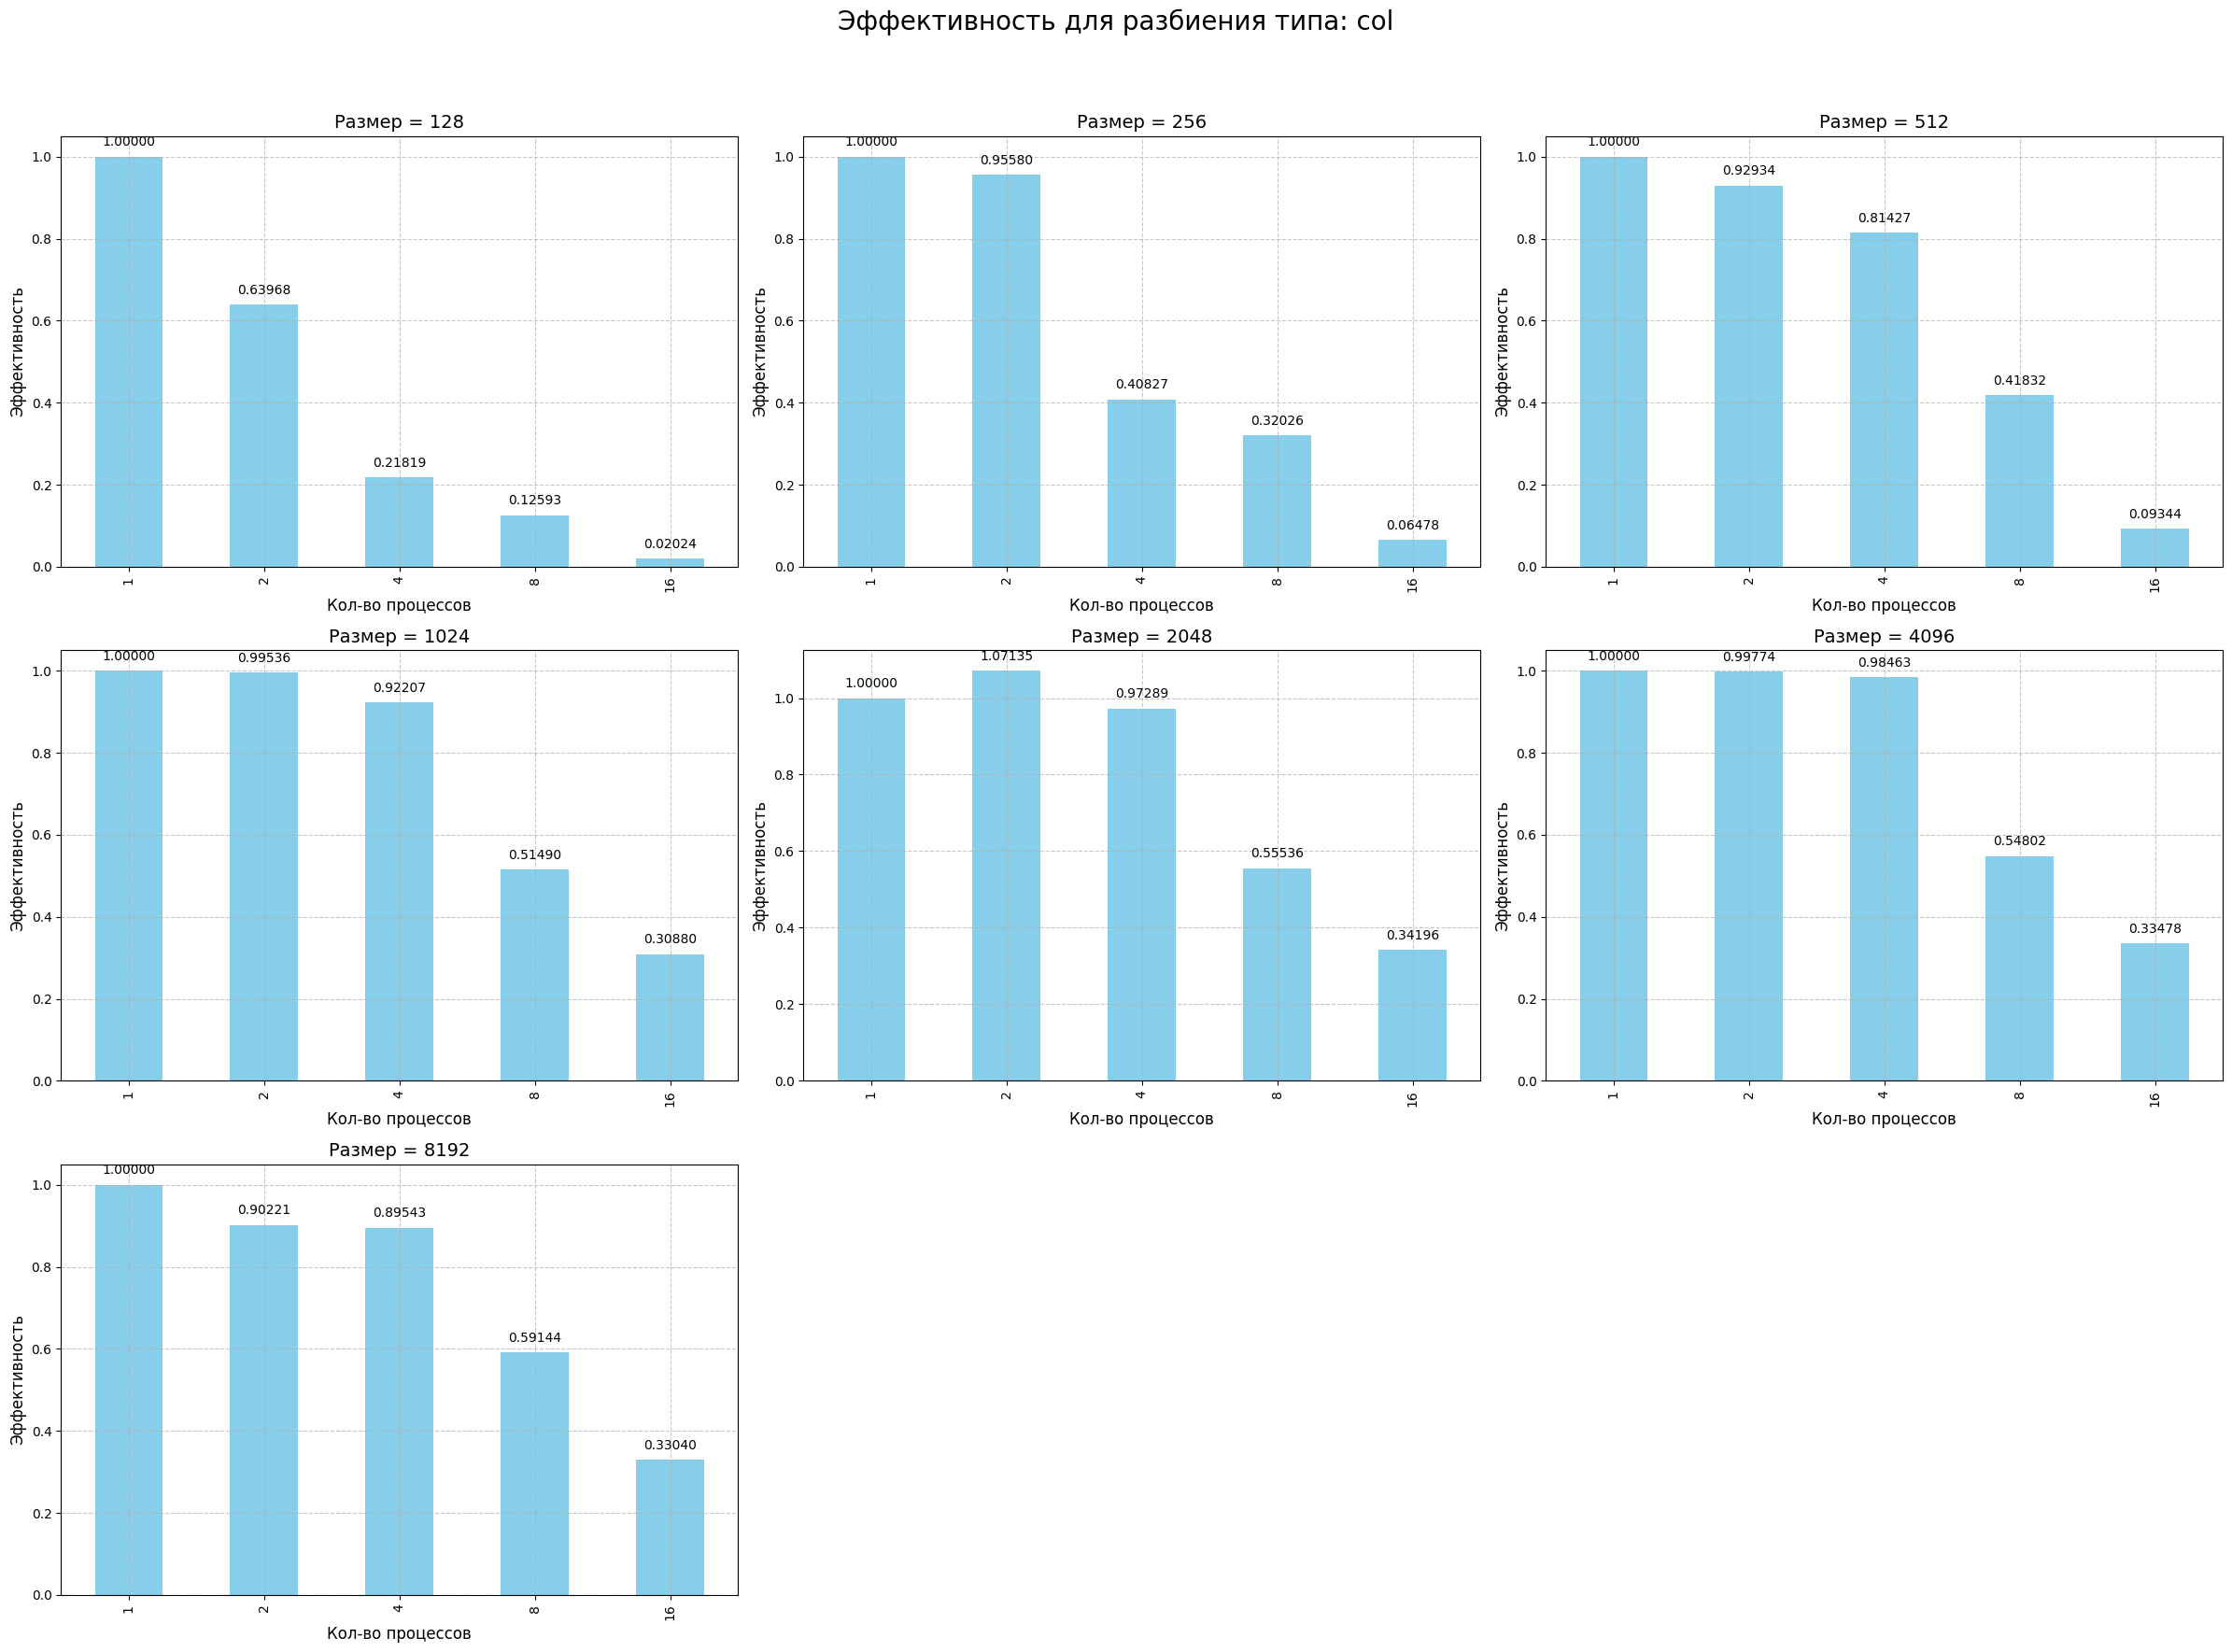

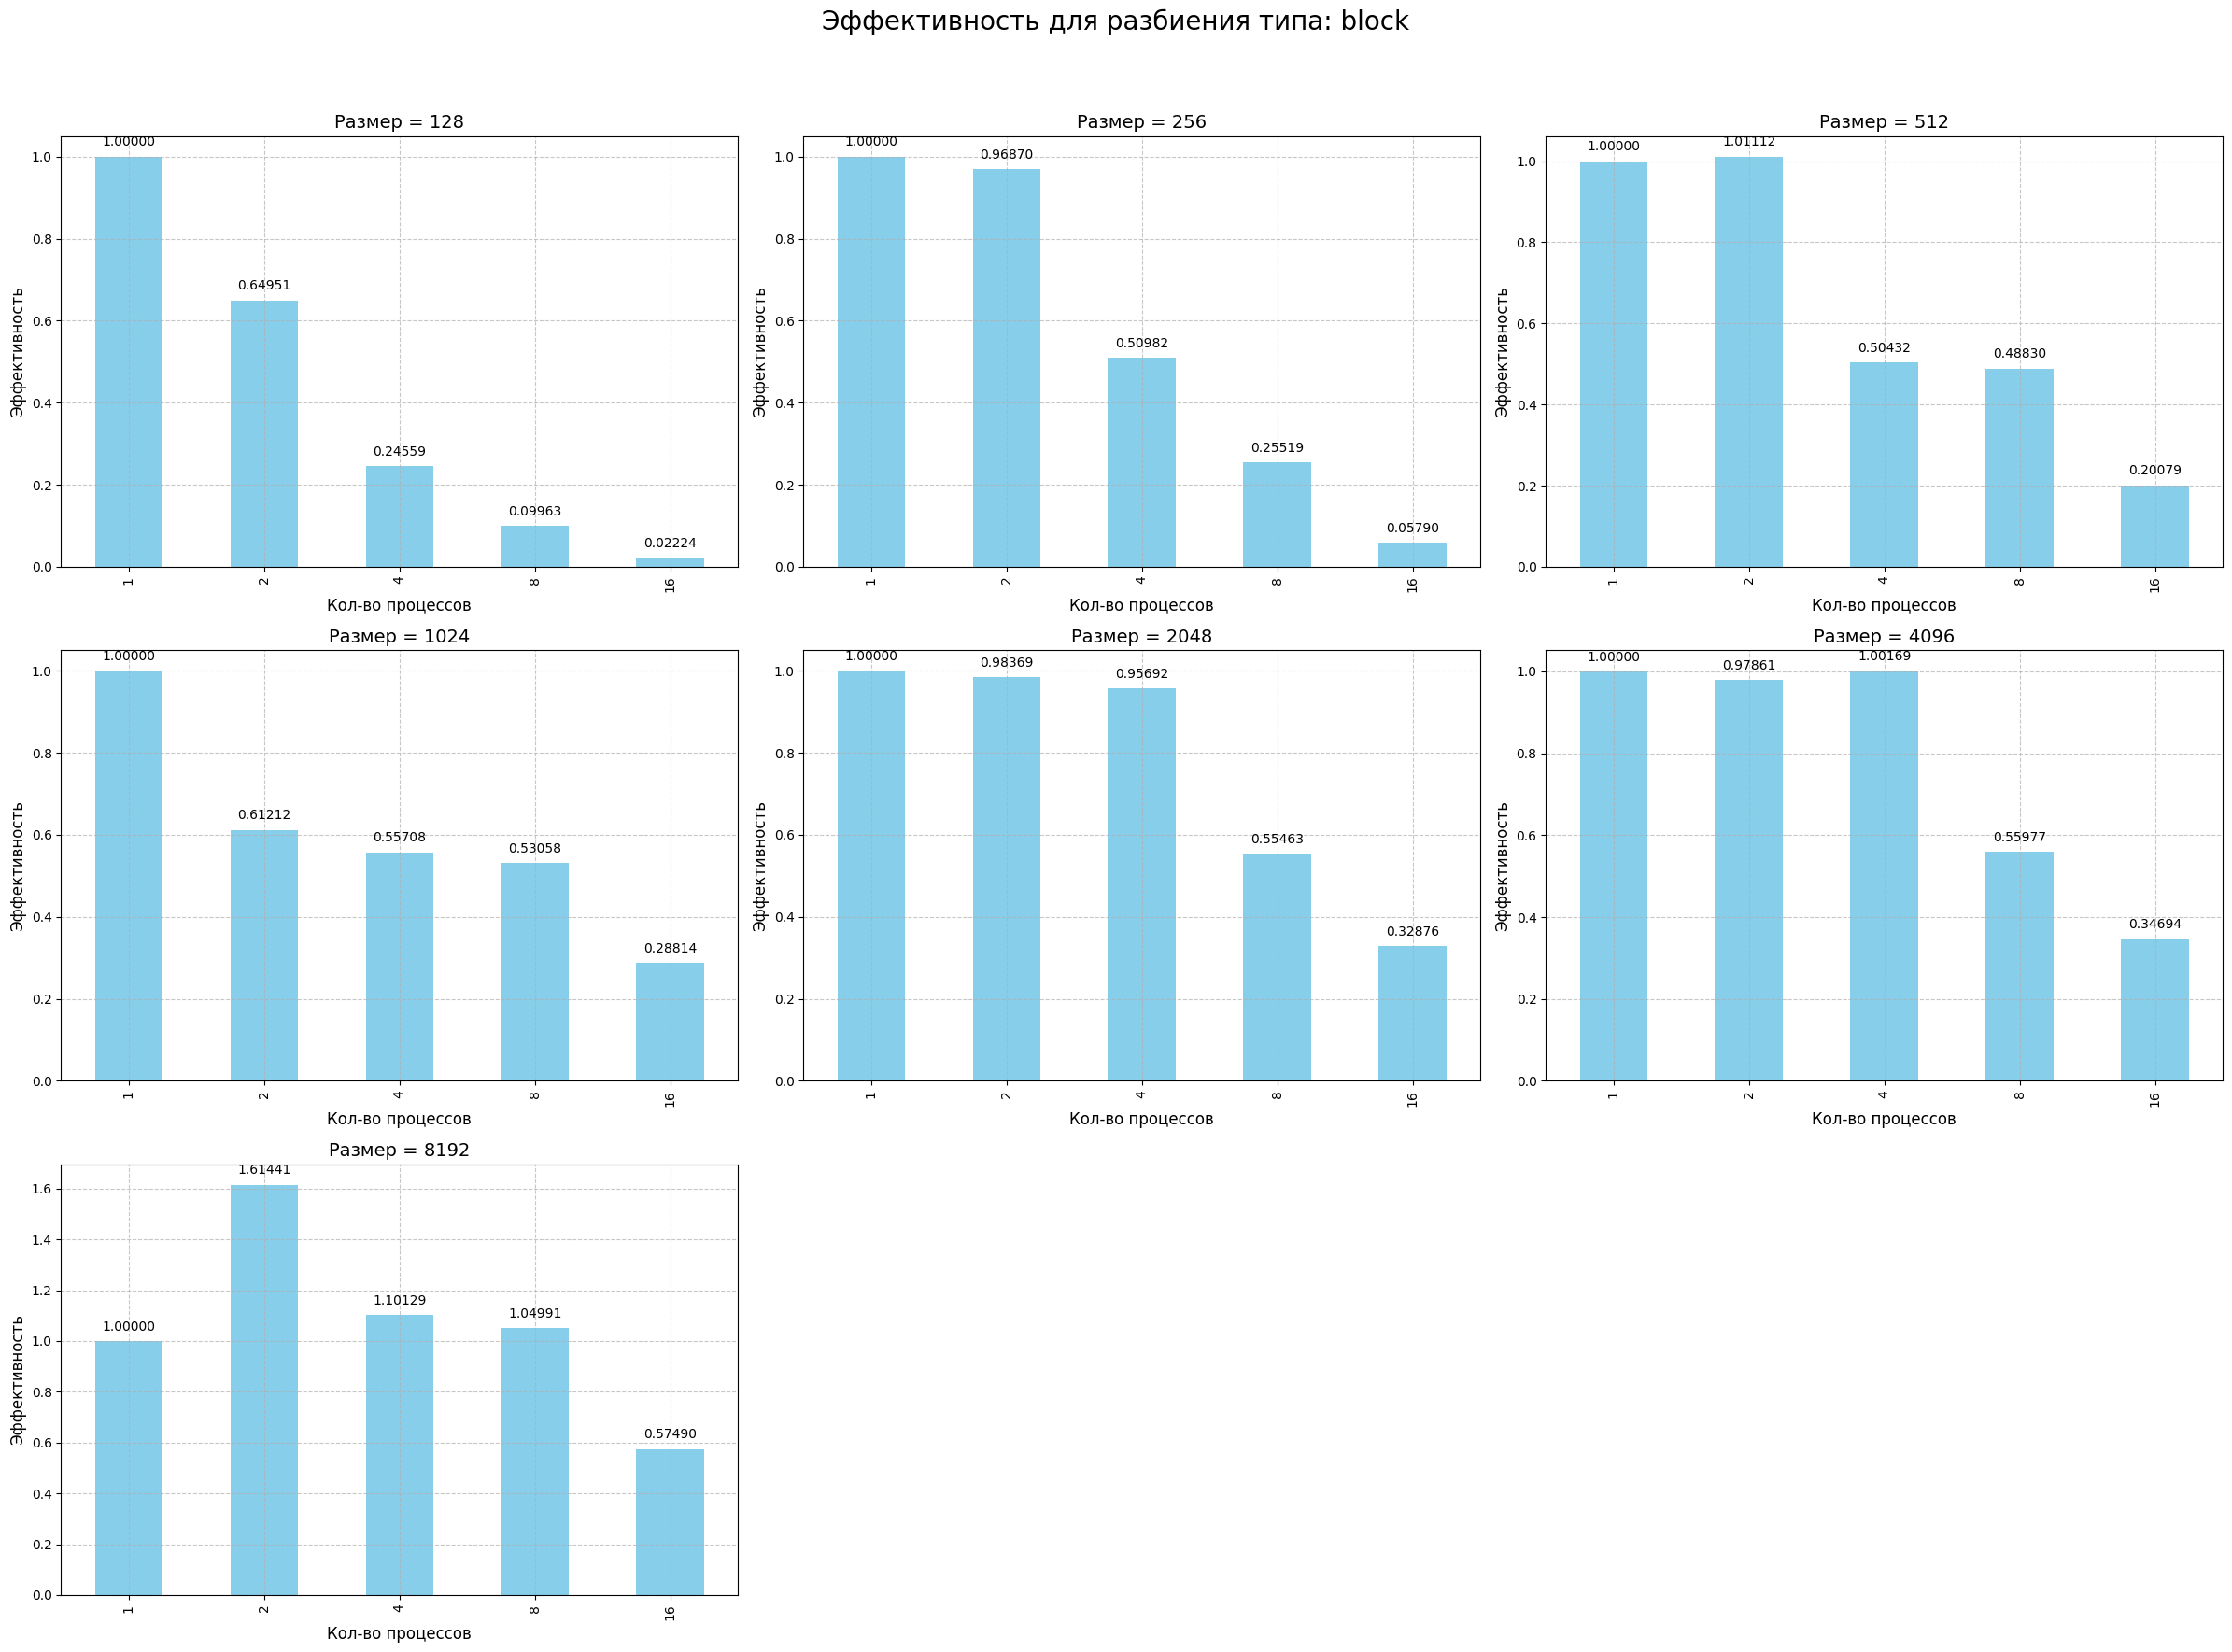

In [ ]:
for partition_type in partition_types:
    filtered_data = results_partitioning[results_partitioning['Partitioning'] == partition_type]

    num_rows = math.ceil(len(size_list) / plots_per_row)
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 8, num_rows * 6))
    fig.suptitle(f'Эффективность для разбиения типа: {partition_type}', fontsize=20)

    axes = axes.flatten()

    for i, size in enumerate(size_list):
        subset = filtered_data[filtered_data['Size'] == size]

        mean_efficiency = subset.groupby('Processes')['Efficiency'].mean()

        ax = axes[i]
        mean_efficiency.plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title(f'Размер = {size}', fontsize=14)
        ax.set_xlabel('Кол-во процессов', fontsize=12)
        ax.set_ylabel('Эффективность', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)

        for p in ax.patches:
            ax.annotate(f"{p.get_height():.5f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom',
                        xytext=(0, 6),
                        textcoords='offset points',
                        fontsize=10)

    for j in range(len(size_list), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


**Зависимость эффективности от числа процессов**

Эффективность (Efficiency = Acceleration / Number_of_Processors) показывает, насколько хорошо используются дополнительные процессы:

- Для маленьких размерностей эффективность резко падает с ростом числа процессов, поскольку ускорение не растёт пропорционально.
- Для больших размерностей эффективность более стабильна и часто находится на высоком уровне. Особенно это заметно для `block` разбиения при больших N, где эффективность может быть близка к 1 (или даже немного выше из-за измерительных погрешностей) при разумном количестве процессов.
  
Например, для `block` при N=8192 и 8 процессах эффективность ~1.0499 – это очень хороший показатель. Для `col` и `row` максимумы эффективности также достигаются при относительно больших задачах и не слишком большом числе процессов.

---

#### Логарифмический график зависимости времени от типа разбиения

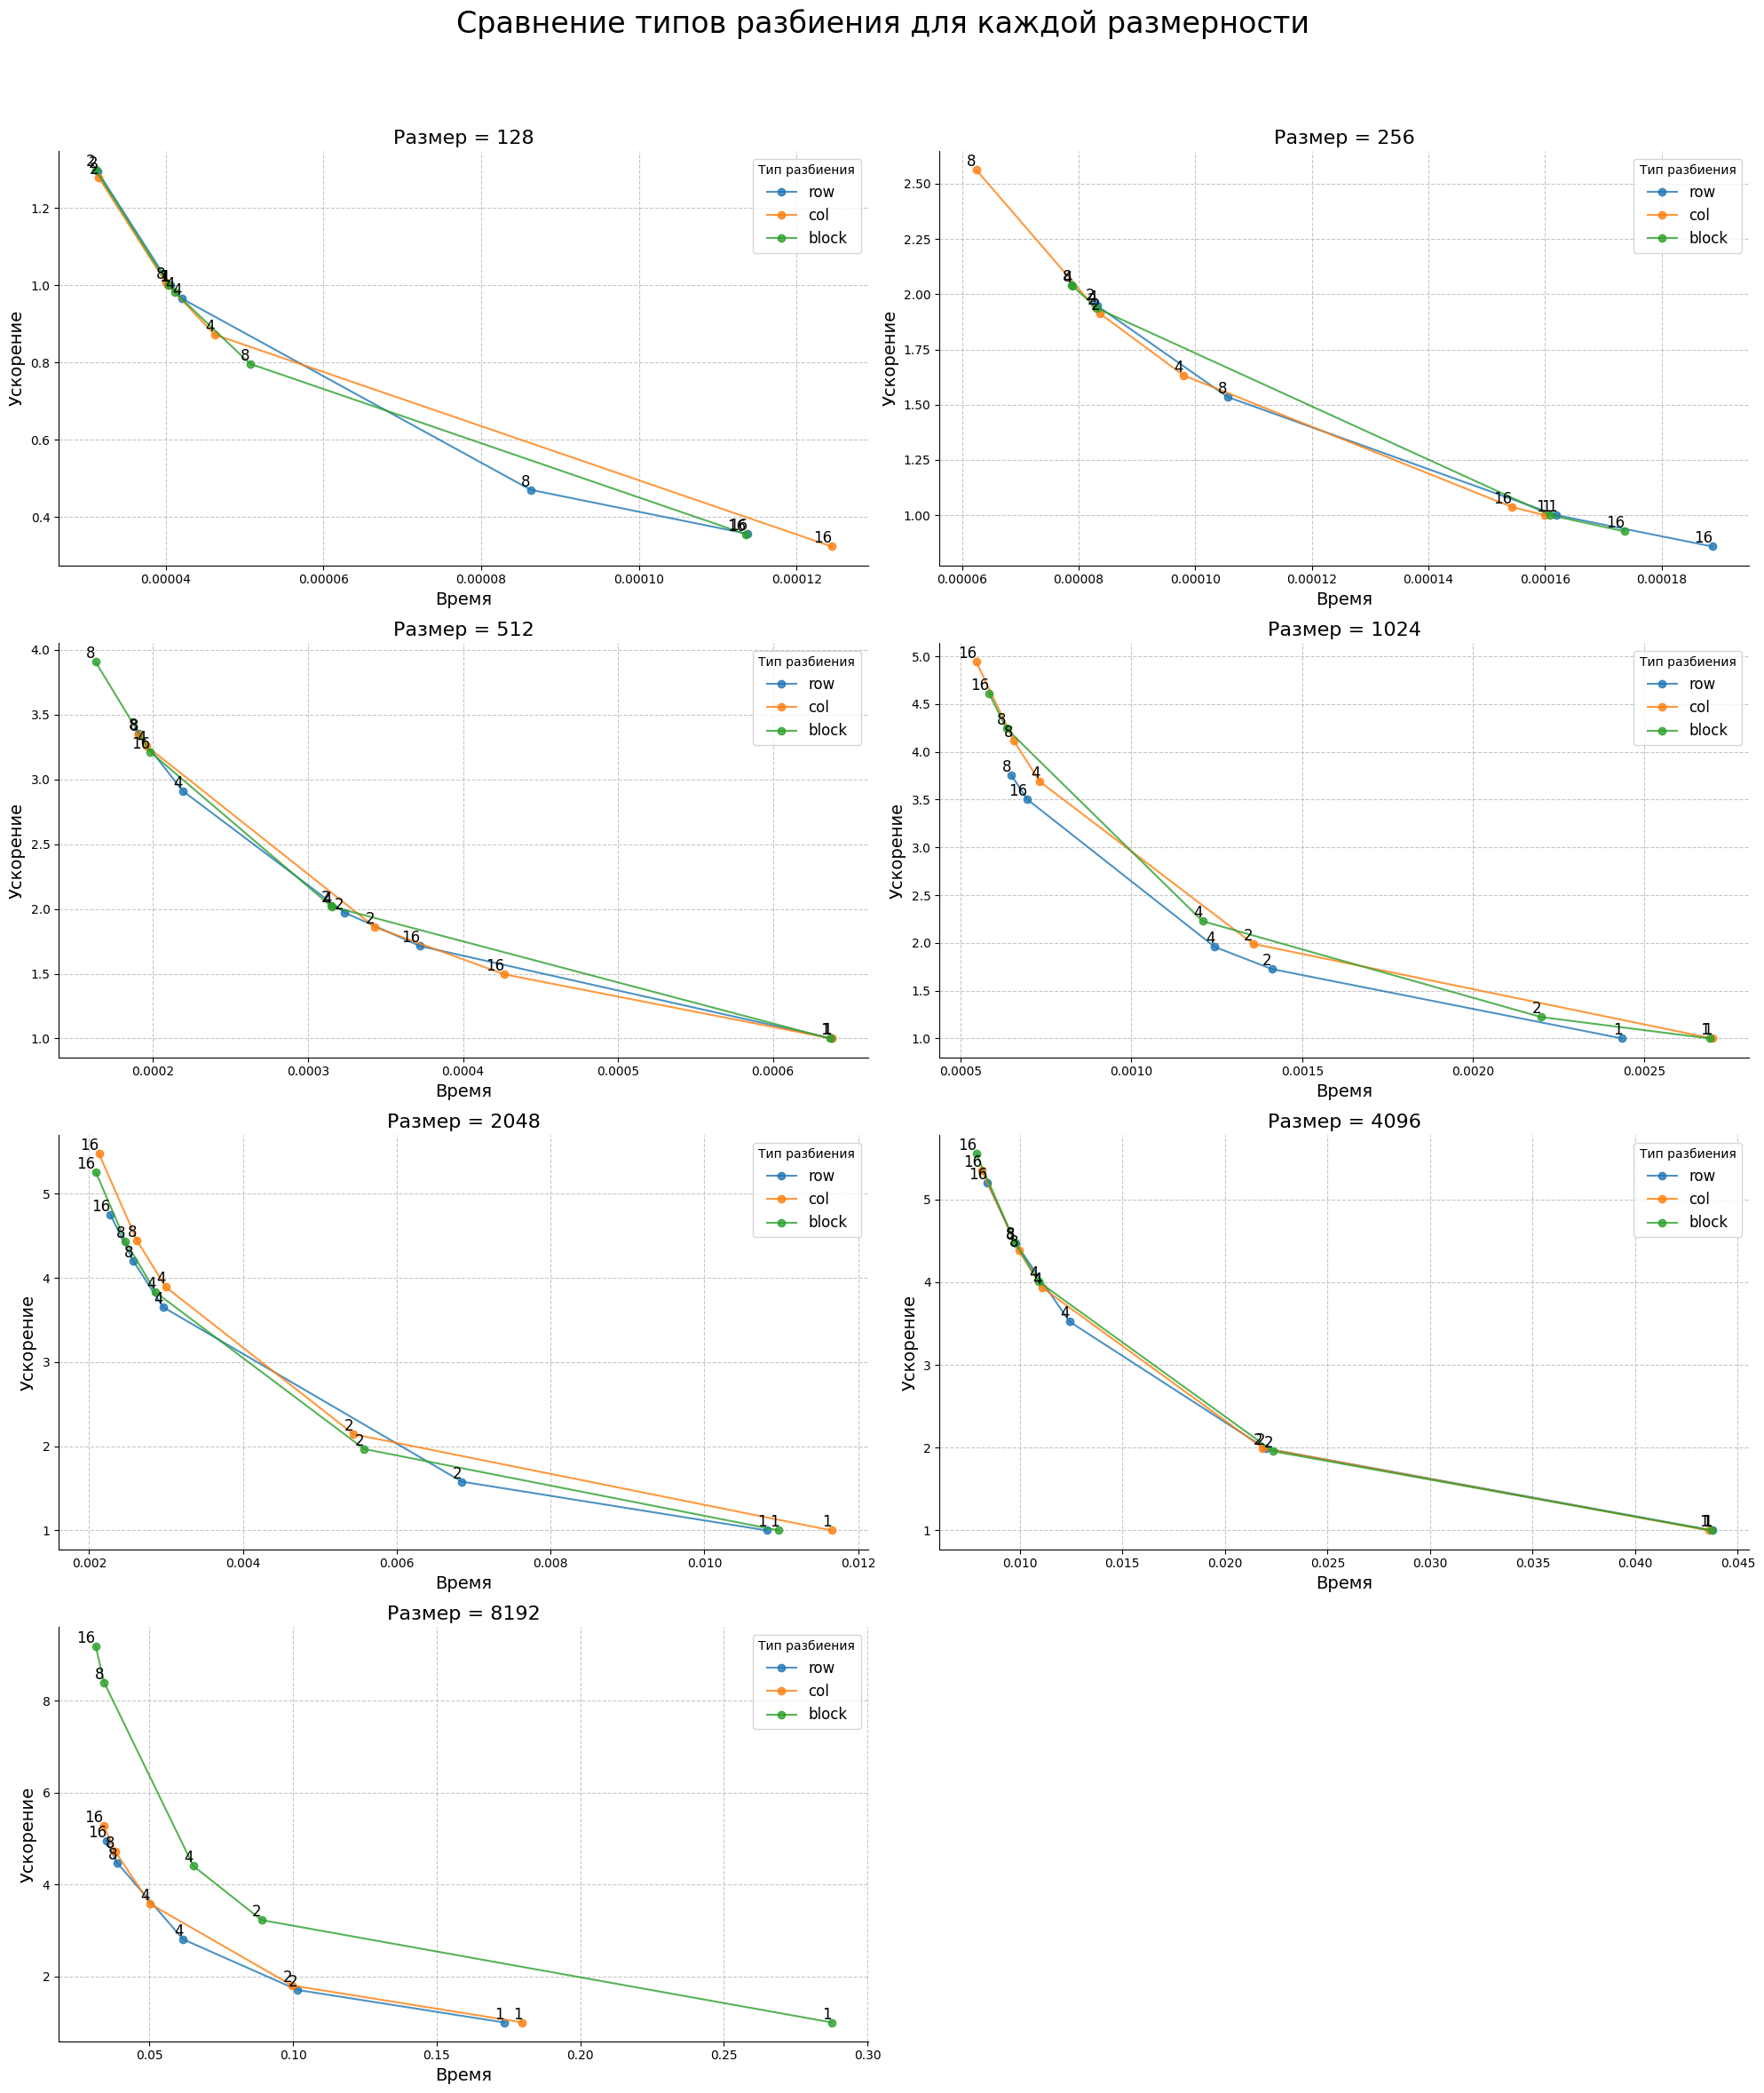

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(2 * 10, 4 * 6))
fig.suptitle('Сравнение типов разбиения для каждой размерности', fontsize=24)
axes = axes.flatten()

for i, size in enumerate(size_list):
    ax = axes[i]

    for partition_type in partition_types:
        subset = results_partitioning[(results_partitioning['Size'] == size) &
                                      (results_partitioning['Partitioning'] == partition_type)]

        subset = subset.sort_values(by='Time')

        ax.plot(subset['Time'], subset['Acceleration'], marker='o', linestyle='-', alpha=0.8, label=partition_type)

        for x, y, processes in zip(subset['Time'], subset['Acceleration'], subset['Processes']):
            ax.text(x, y, f'{processes}', fontsize=12, ha='right', va='bottom')

    ax.set_title(f'Размер = {size}', fontsize=16)
    ax.set_xlabel('Время', fontsize=14)
    ax.set_ylabel('Ускорение', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend(title='Тип разбиения', fontsize=12)

for j in range(len(size_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Малые размеры (например, N=128):**

- **Block**: При 1 процессе время минимально, но при увеличении числа процессов выгода быстро снижается и даже может теряться. Ускорение при небольшом числе процессов чуть выше 1, но при 8 или 16 процессах ускорение падает ниже единицы, что говорит о потере производительности.
- **Col**: Аналогичная ситуация, при малом размере выгода от параллелизации невелика. Ускорение при 2 процессах немного выше 1, но дальнейший рост числа процессов даёт небольшой или отрицательный эффект.
- **Row**: Очень похожее поведение на малом размере. Рост числа процессов свыше 2-4 практически не даёт улучшений, а иногда и ухудшает ситуацию из-за накладных расходов.

**Вывод для мелких матриц:** Все три метода дают примерно сходную картину — при увеличении числа процессов сверх 2-4 наблюдается снижение эффективности. Ни один метод существенно не превосходит другие для очень маленьких размерностей, так как вычислительная нагрузка недостаточно велика, чтобы компенсировать коммуникационные накладные расходы.

---

**Средние размеры (например, N=1024, N=2048):**

- **Block**: Начинает показывать лучшие результаты при увеличении числа процессов. Ускорение в диапазоне 4-8 процессов может быть существенно выше 2, а иногда и превышать 4–5. Эффективность для умеренного числа процессов остаётся на хорошем уровне.
- **Col**: Демонстрирует близкие к `block` результаты. При 4-8 процессах ускорение часто около 3–4, эффективность хотя и падает с ростом числа процессов, остаётся приемлемой. Методы col и block идут «ноздря в ноздрю» на средних размерностях.
- **Row**: Тоже улучшается с ростом размера, но иногда немного уступает block и col по ускорению или эффективности при большом числе процессов. Тем не менее, разница не критична и row также получает ощутимую выгоду от параллелизации.

**Вывод для средних матриц:** Все три метода демонстрируют уверенное ускорение, особенно при 4–8 процессах. Block и col нередко чуть предпочтительнее, давая более стабильное высокое ускорение и эффективность, но row ненамного отстаёт.

---

**Крупные размеры (например, N=4096, N=8192):**

- **Block**: На больших размерностях метод block наиболее полно раскрывает потенциал параллелизма. Можно наблюдать ускорения, превышающие 4–5 при 8 процессах, а при 16 процессах ускорение может быть ещё выше. Эффективность при этом остаётся на достаточно хорошем уровне.
- **Col**: На больших задачах col-разбиение также масштабируется хорошо. Ускорения 3–5 при 8 процессах достаточно типичны, а эффективность остаётся на приемлемом уровне. Хотя результаты часто близки к block, иногда block чуть лучше справляется с увеличением числа процессов.
- **Row**: По мере увеличения размерности row также даёт значительное ускорение и неплохую эффективность. При очень больших матрицах показатели row нередко сопоставимы с col, но могут чуть уступать block в некоторых случаях.

**Вывод для больших матриц:** Все три метода существенно выигрывают от параллелизации. Однако, block-разбиение чаще всего оказывается немного впереди, демонстрируя более высокое ускорение и эффективность для максимальных размерностей. Col-разбиение идёт за ним с близкими результатами, а row, хотя и менее стабилен в некоторых случаях, также показывает значительный прирост.

---

### Общие выводы

**Сравнение методов в целом:**

- **Block-разбиение**:  
  Показывает наиболее стабильный рост ускорения и хорошую эффективность на больших размерностях. Для очень крупных матриц (4096, 8192) метод block выходит в лидеры по эффективности использования ресурсов.

- **Col-разбиение**:  
  Довольно близко к `block` по результатам на средних и больших размерностях. На крупных задачах также достигает высокой ускоряемости (3-5 раз и более) и приемлемой эффективности, особенно при разумном числе процессов (4-8).

- **Row-разбиение**:  
  Похожая картина, но иногда чуть меньшая эффективность на больших системах, чем `block`, хотя также показывает хороший прирост производительности при росте числа процессов для крупных матриц. На мелких задачах, как и остальные, страдает от избыточного параллелизма.

---

**Итог:**

1. **Время vs число процессов:**  
  - Для мелких матриц увеличение числа процессов сверх 2-4 не приносит пользы.  
  - Для крупных матриц время существенно уменьшается при росте числа процессов.

2. **Время vs размерность матрицы:**  
  - Время растёт с размером задачи, но параллелизация позволяет это время сильно сократить для больших матриц.

3. **Ускорение vs число процессов:**  
  - На маленьких задачах ускорение может даже упасть ниже 1 при слишком большом числе процессов.  
  - На больших задачах ускорение достигает и превышает линейный рост, особенно в случае `block`-разбиения.

4. **Эффективность vs число процессов:**  
  - Для маленьких матриц эффективность резко падает с ростом числа процессов.  
  - Для крупных задач эффективность может быть высокой, особенно при умеренных (4-8) количествах процессов и `block`-разбиении.

5. **Тип разбиения vs размерность матрицы:**  
  - Для очень больших задач метод block обычно наиболее эффективен.  
  - Col-разбиение показывает схожие результаты на крупных задачах и может быть альтернативой block.  
  - Row-разбиение хорошо масштабируется на больших матрицах, но обычно чуть уступает двум другим методам при больших количествах процессов.

В целом, параллельное умножение матрицы на вектор наиболее эффективно для больших размерностей, и наибольшую выгоду при увеличении числа процессов зачастую даёт блочное (`block`) разбиение, хотя и другие подходы (столбцовое `col` и строковое `row`) тоже показывают улучшения на больших задачах (при матрицах большого размера).

## Алгоритм Кэннона

### Описание алгоритма

**Объявление и инициализация:**

1. Инициализируется среда MPI с помощью вызова `MPI_Init`.
2. Получается ранг текущего процесса (`rank`) и общее количество процессов (`size`) с помощью `MPI_Comm_rank` и `MPI_Comm_size`.
3. Вычисляется `sqrt_size = sqrt(size)`. Предполагается, что количество процессов образует квадрат (`size = p²`), что необходимо для формирования двумерной процессорной решётки `sqrt_size x sqrt_size`. Если это условие не выполняется, программа завершается.
4. Проверяется наличие аргумента командной строки `n` – размерности перемножаемых квадратных матриц A и B. Если аргумент отсутствует или некорректен, программа завершается.
5. Проверяется, что `n` делится на `sqrt_size` без остатка. Это необходимо для равномерного распределения блоков матриц по процессам. Если условие не выполняется, программа завершается.

**Определение параметров задачи:**

1. Рассчитывается `block_size = n / sqrt_size` – размер локального блока матрицы, который будет храниться и обрабатываться каждым процессом.
2. Выделяются локальные массивы для блоков матриц: `local_A`, `local_B`, `local_C` размером `block_size * block_size`. Изначально `local_C` заполняется нулями, так как в нём будет накапливаться результат частичного произведения блоков.
3. Для процесса с рангом 0 (главный процесс) выделяются и инициализируются полные матрицы A и B размером `n x n`. Генерация значений осуществляется случайным образом в диапазоне от -10.0 до 10.0. Другие процессы пока не имеют данных о полной матрице.

**Распределение данных:**

1. Создаётся двумерная топология процессов с помощью `MPI_Cart_create`, задаётся размерность `dims = {sqrt_size, sqrt_size}` и цикличность (periods = {1, 1}) для удобства циклических сдвигов.
2. Для каждого процесса определяется его позиция в решётке (координаты `coords[0]`, `coords[1]`).
3. Главный процесс (rank 0) разбивает полные матрицы A и B на блоки размером `block_size x block_size` и рассылает их соответствующим процессам. Каждый процесс получает по одному блоку A и B. Для процесса 0 копирование происходит напрямую, для остальных – отправка с помощью `MPI_Send`.
4. Остальные процессы (rank != 0) получают свои локальные блоки A и B через `MPI_Recv`.

**Начальное выравнивание блоков по Каннону:**

1. Выполняется начальный сдвиг локальных данных:
   - Матрица A сдвигается влево на число шагов, равное координате по строке (`coords[0]`), используя `MPI_Cart_shift` и `MPI_Sendrecv_replace`.
   - Матрица B сдвигается вверх на число шагов, равное координате по столбцу (`coords[1]`), таким же образом.
   
   После этих сдвигов каждый процесс располагает такие блоки A и B, что готов к первому шагу умножения согласно алгоритму Каннона.

**Основной цикл перемножения (Алгоритм Каннона):**

1. Запускается основной цикл умножения на `sqrt_size` итераций. На каждой итерации:
   - Происходит умножение локальных блоков `local_A * local_B` и результат прибавляется к `local_C`.
   - После умножения локальные блоки A сдвигаются влево на один процесс, а локальные блоки B – вверх на один процесс (циклический сдвиг). Для этого повторно вызываются `MPI_Cart_shift` и `MPI_Sendrecv_replace`.
   
   Таким образом, после каждой итерации блоки A и B «ходят по кругу», последовательно перемножаясь с разными блоками, пока не будет обработано `sqrt_size` различных сочетаний блоков.

**Сбор и анализ результатов:**

1. По завершении всех итераций у каждого процесса в `local_C` находится его часть результата произведения матриц.
   
   Примечание: Данный код не собирает итоговую матрицу C обратно на один процесс. Он только измеряет время выполнения.
   
2. Измеряется время выполнения с помощью `MPI_Wtime` до и после вычислений.
3. С помощью `MPI_Reduce` собирается суммарное время `total_time` и минимальное время `minimal_time` среди всех процессов.
4. На процессе 0 результаты записываются в файл:
   - `total_time / size` – среднее время выполнения программы каждым процессором.
   - `minimal_time` – минимальное время потраченное на выполнение программы среди всех процессоров.

**Завершение:**

1. Закрывается файл результатов.
2. Вызывается `MPI_Finalize()` для завершения работы MPI.
3. Программа завершается.

---

### Графики для умножения матриц по алгоритму Кэннона

In [ ]:
import math

partition_types = results_partitioning['Partitioning'].unique()
size_list = results_partitioning['Size'].unique()
plots_per_row = 3

#### Зависимость времени от размерности матрицы для разных количеств процессов

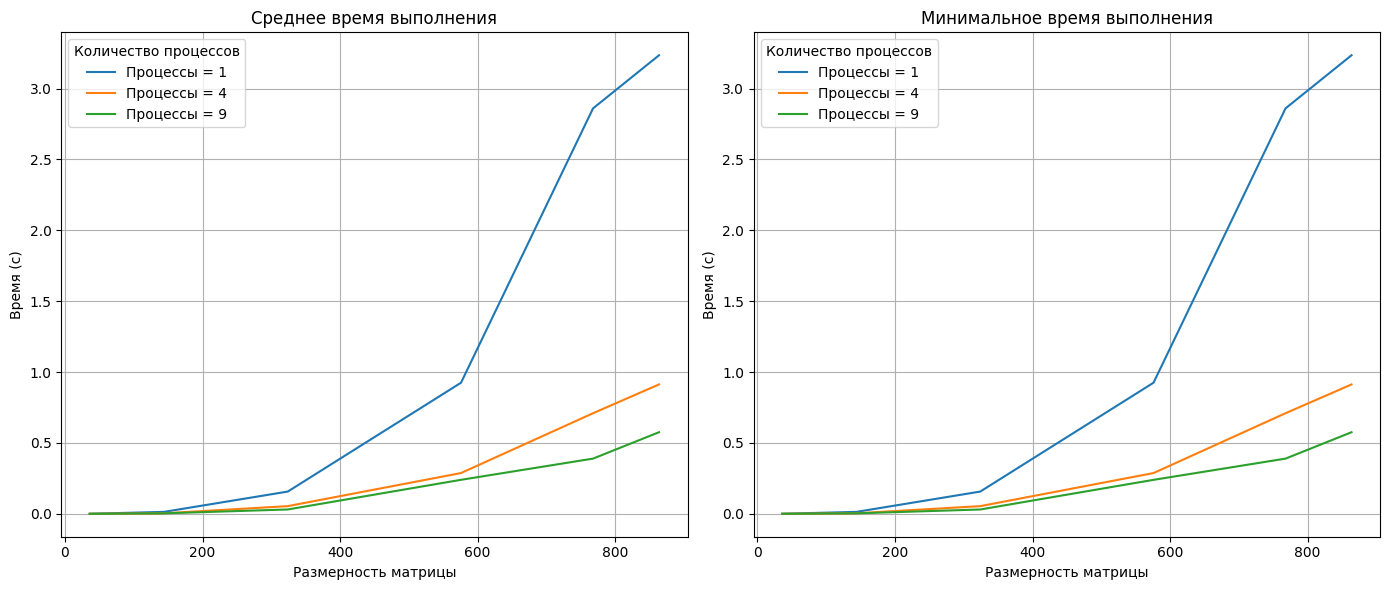

In [ ]:
processes_list = results_kanon['Processes'].unique()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# График среднего времени
for num_procs in processes_list:
    subset = results_kanon[results_kanon['Processes'] == num_procs]
    axs[0].plot(subset['Size'], subset['Time'], label=f'Процессы = {num_procs}')

axs[0].legend(title='Количество процессов')
axs[0].set_title('Среднее время выполнения')
axs[0].set_xlabel('Размерность матрицы')
axs[0].set_ylabel('Время (с)')
axs[0].grid(True)

# График минимального времени
for num_procs in processes_list:
    subset = results_kanon[results_kanon['Processes'] == num_procs]
    axs[1].plot(subset['Size'], subset['Min time'], label=f'Процессы = {num_procs}')

axs[1].legend(title='Количество процессов')
axs[1].set_title('Минимальное время выполнения')
axs[1].set_xlabel('Размерность матрицы')
axs[1].set_ylabel('Время (с)')
axs[1].grid(True)

plt.tight_layout()
plt.show()


**Зависимость времени от количества процессоров**

Изменение времени при фиксированном размере матрицы при увеличении числа процессов:

- **Size=36 (малый размер)**:
  - 1 процесс: 0.000269 сек
  - 4 процесса: 0.000186 сек (время снижается)
  - 9 процессов: 0.000365 сек (время снова растёт, что указывает на рост накладных расходов при слишком большом числе процессов для столь маленькой задачи)

- **Size=768 (крупный размер)**:
  - 1 процесс: 2.859860 сек
  - 4 процесса: 0.709568 сек (значительно быстрее)
  - 9 процессов: 0.389417 сек (ещё лучше, масштабирование идёт в плюс)

Аналогичная тенденция прослеживается и для других крупных размерностей: при увеличении числа процессов время существенно сокращается. Таким образом, для малых размерностей слишком много процессов ухудшает производительность (из-за коммуникационных затрат), тогда как для больших размеров время стабильно уменьшается с ростом количества процессов.

---

#### Среднее время выполнения для размерности матрицы

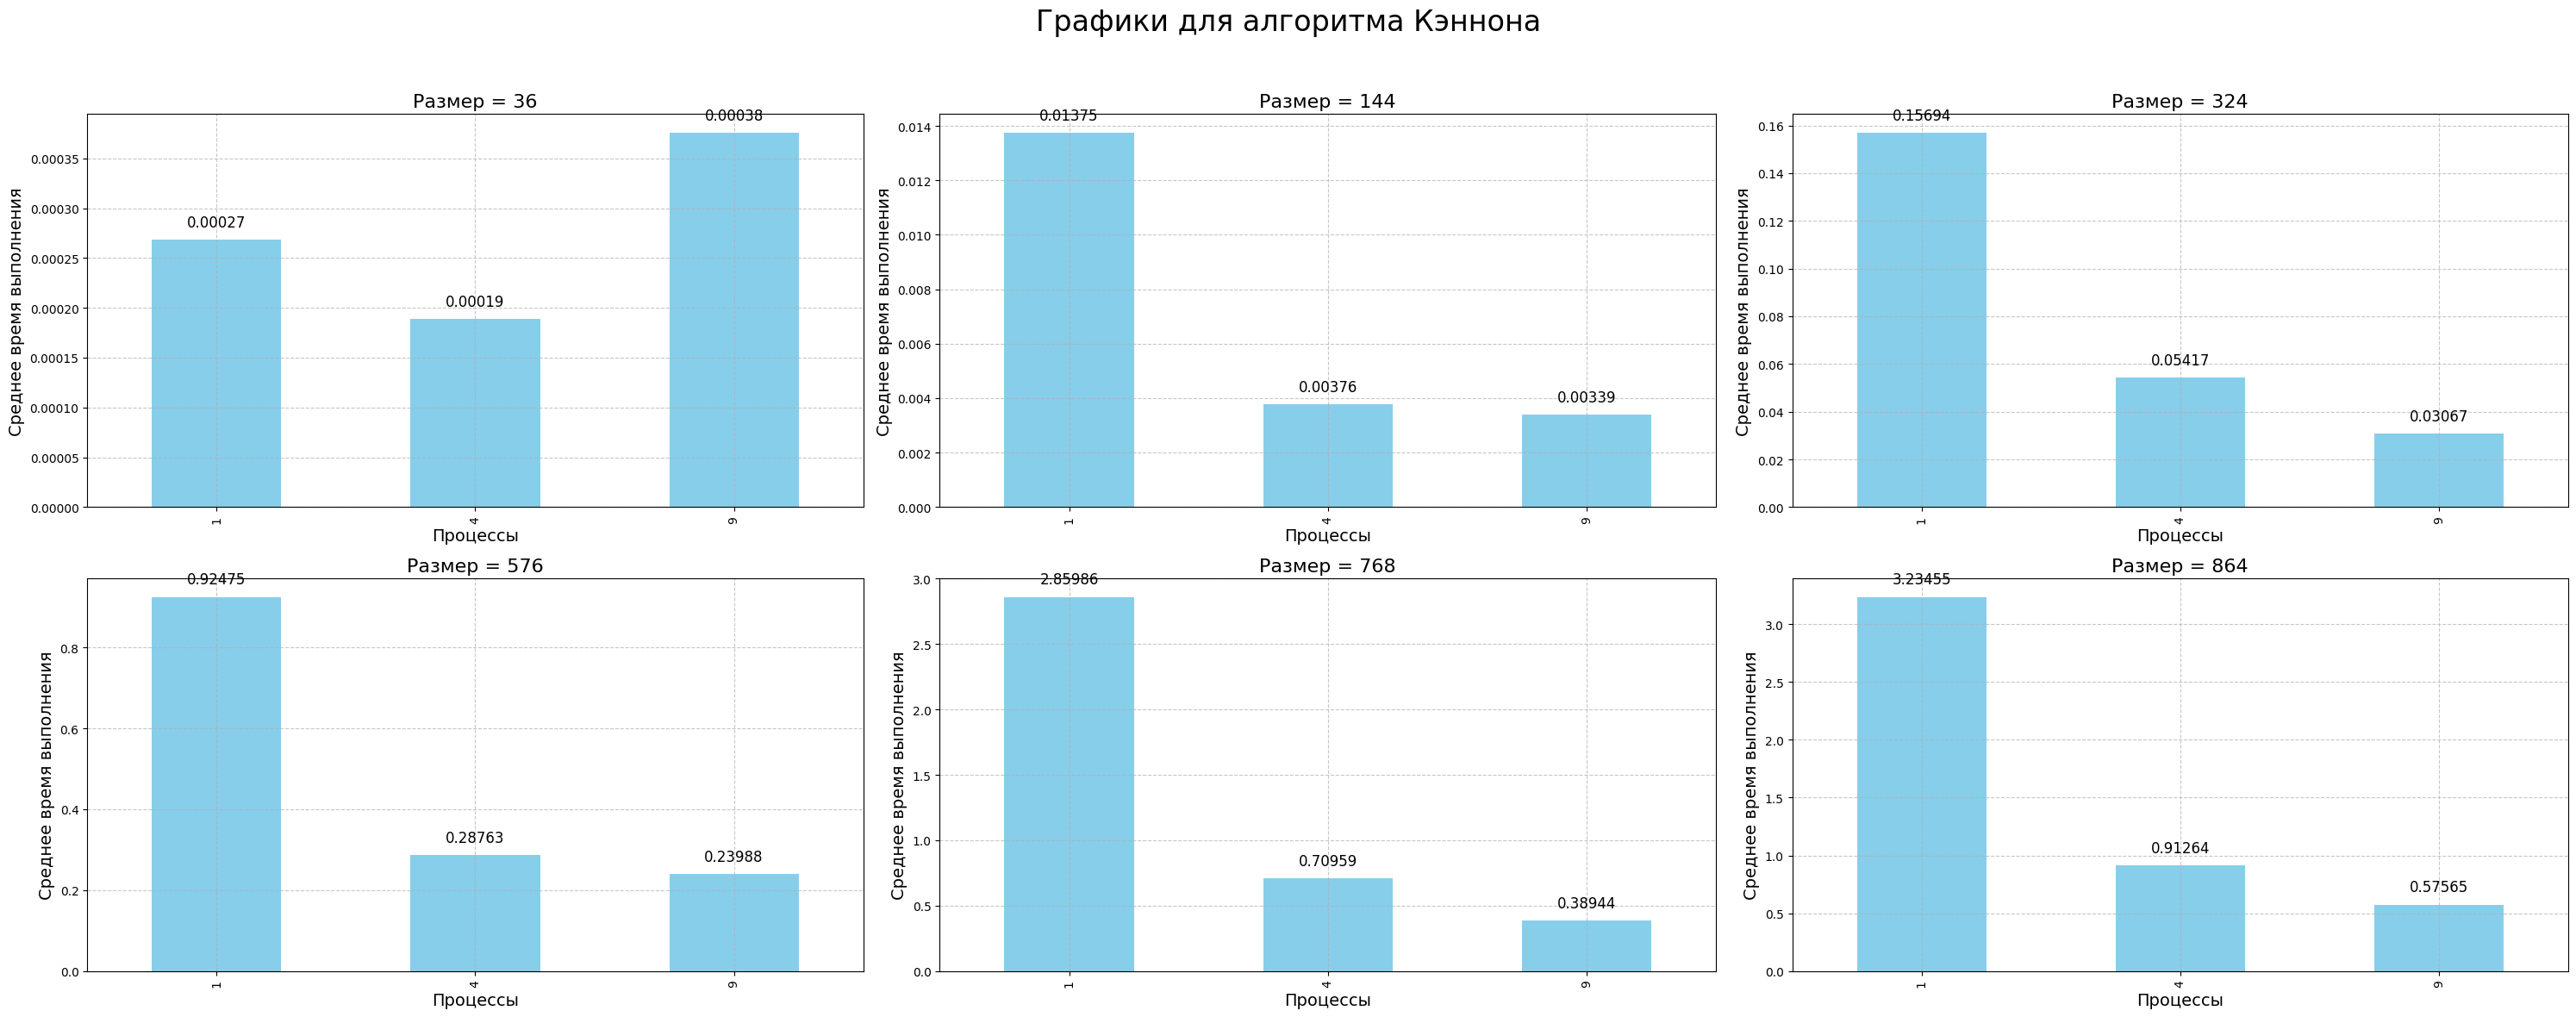

In [ ]:
num_rows = math.ceil(len(size_list) / plots_per_row)
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 10, num_rows * 6))
fig.suptitle(f'Графики для алгоритма Кэннона', fontsize=24)

axes = axes.flatten()

for i, size in enumerate(size_list):
    subset = results_kanon[results_kanon['Size'] == size]

    mean_times = subset.groupby('Processes')['Time'].mean()

    ax = axes[i]
    mean_times.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'Размер = {size}', fontsize=16)
    ax.set_xlabel('Процессы', fontsize=14)
    ax.set_ylabel('Среднее время выполнения', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.5f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    xytext=(0, 8),
                    textcoords='offset points',
                    fontsize=12)

for j in range(len(size_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Значение времени выполнения при разных размерностях матрицы**

При фиксированном числе процессов время сильно зависит от размера:

- При 1 процессе:
  - N=36: ~0.000269 сек
  - N=144: ~0.013748 сек
  - N=324: ~0.156943 сек
  - N=576: ~0.924748 сек
  - N=768: ~2.859860 сек
  - N=864: ~3.234550 сек

Рост времени с увеличением N соответствует сложностному росту O(N³) умножения матриц. Аналогично, при 4 и 9 процессах общая тенденция та же, но абсолютные времена меньше. Чем больше матрица, тем сильнее выигрывает параллелизация.

---

#### График зависимости ускорения от количества процессоров

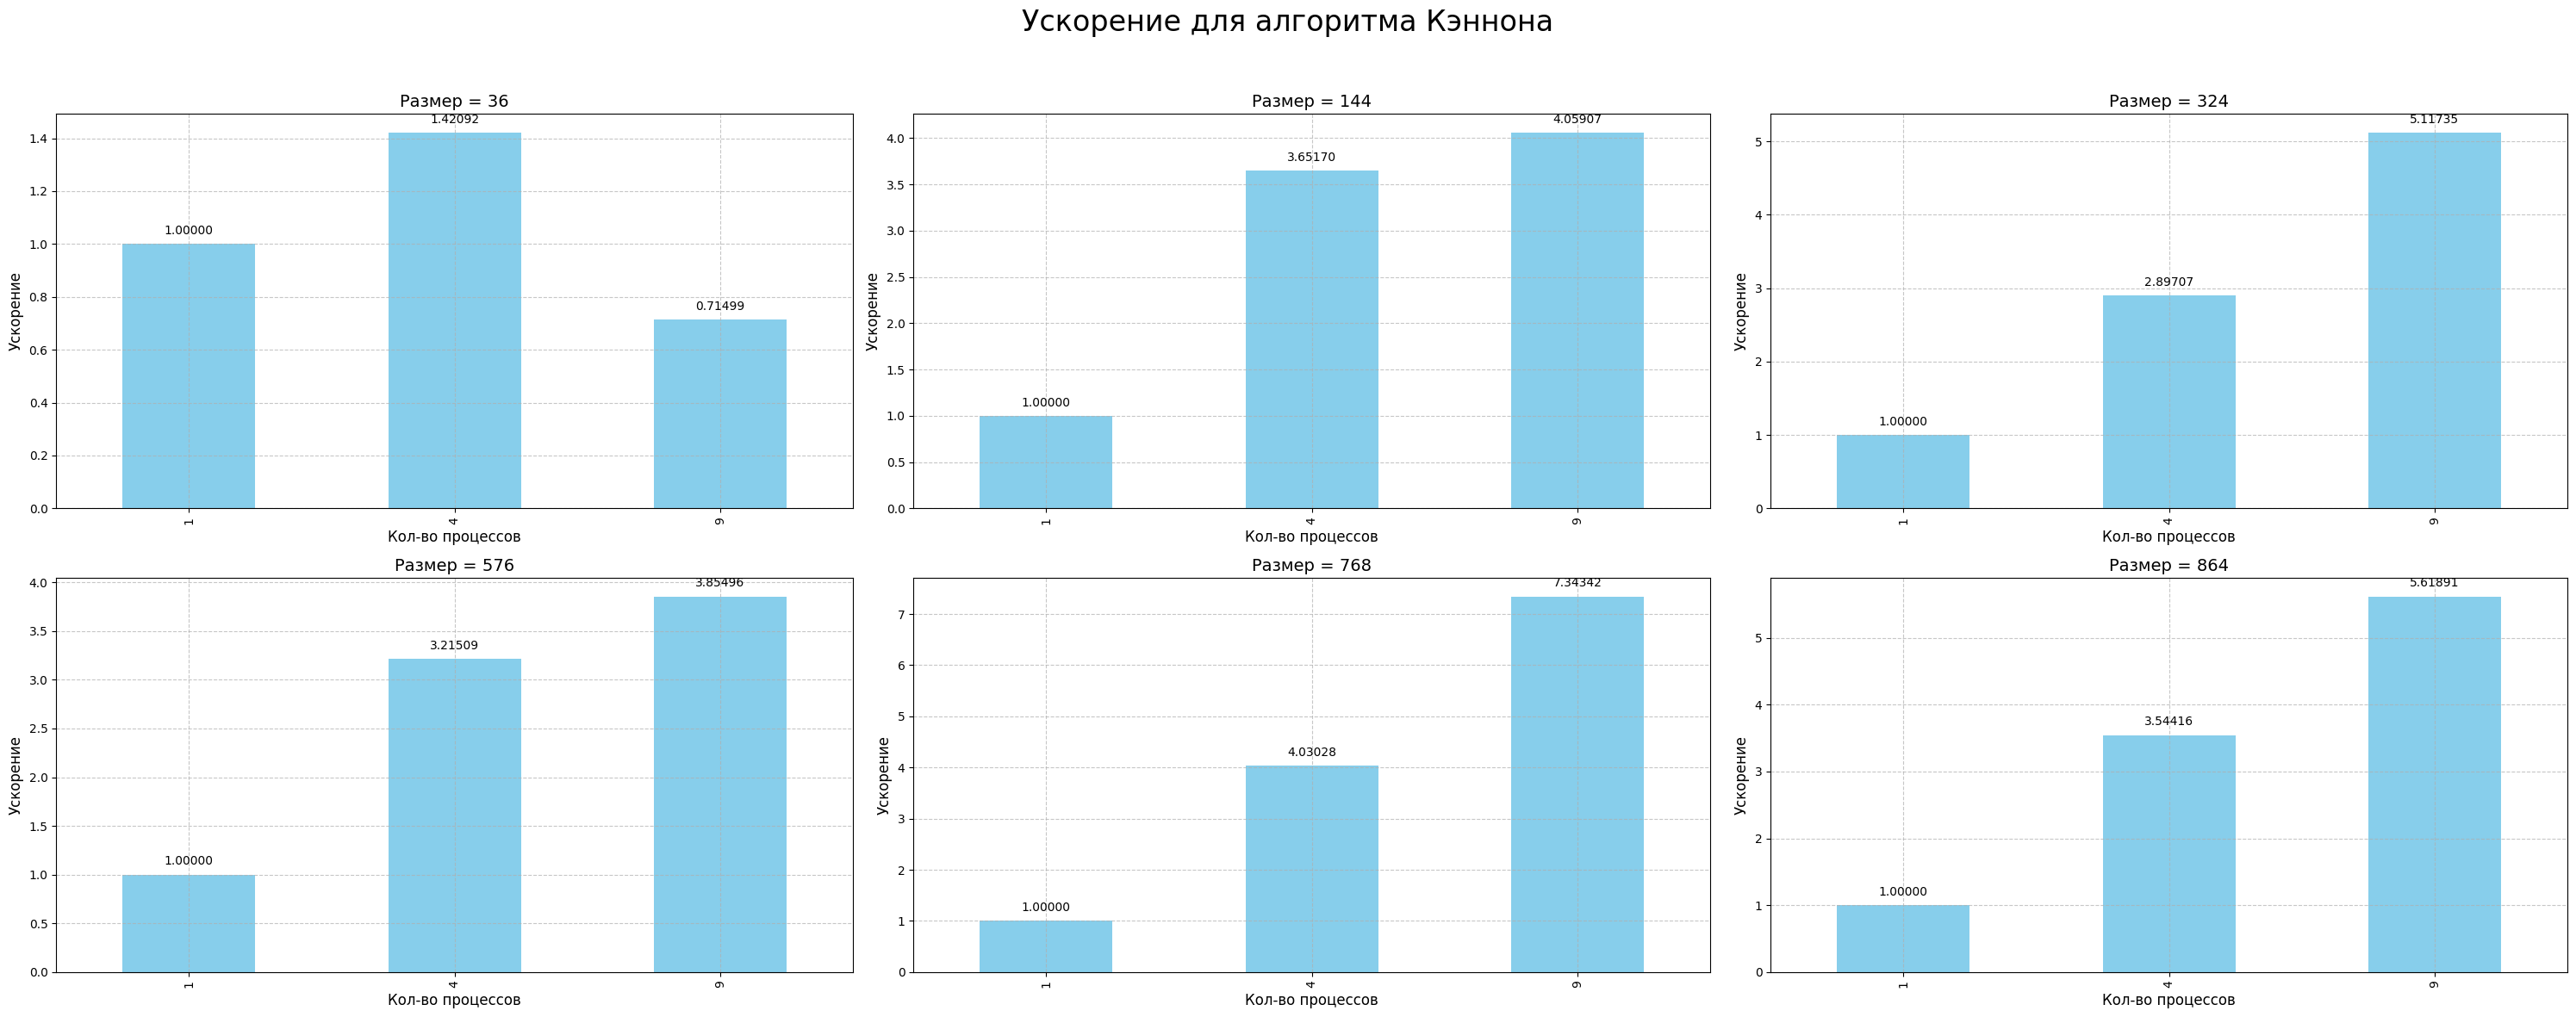

In [ ]:
num_rows = math.ceil(len(size_list) / plots_per_row)
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 10, num_rows * 6))
fig.suptitle(f'Ускорение для алгоритма Кэннона', fontsize=24)

axes = axes.flatten()

for i, size in enumerate(size_list):
    subset = results_kanon[results_kanon['Size'] == size]

    mean_acceleration = subset.groupby('Processes')['Acceleration'].mean()

    ax = axes[i]
    mean_acceleration.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'Размер = {size}', fontsize=14)
    ax.set_xlabel('Кол-во процессов', fontsize=12)
    ax.set_ylabel('Ускорение', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.5f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    xytext=(0, 6),
                    textcoords='offset points',
                    fontsize=10)

for j in range(len(size_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Зависимость ускорения от количества процессоров**

Ускорение (Acceleration = T(1)/T(p)) показывает, насколько быстрее выполняется программа при использовании p процессов, по сравнению с последовательным вариантом.

- Для маленькой задачи (N=36):
  - 4 процесса: ускорение ~1.42 (небольшое улучшение)
  - 9 процессов: ускорение ~0.71 (хуже последовательного, т.е. переизбыток процессов невыгоден)

- Для большой задачи (N=768):
  - 4 процесса: ускорение ~4.03 (очень хорошее, почти линейное)
  - 9 процессов: ускорение ~7.34 (даже превосходит линейный рост относительно 1 процесса)

Для крупных задач ускорение с ростом числа процессов значительно лучше, приближаясь к или даже превышая ожидаемый линейный скейлинг за счёт снижения доли последовательных частей и более полной загрузки вычислительных узлов.

---

#### График зависимости эффективности от количества процессоров

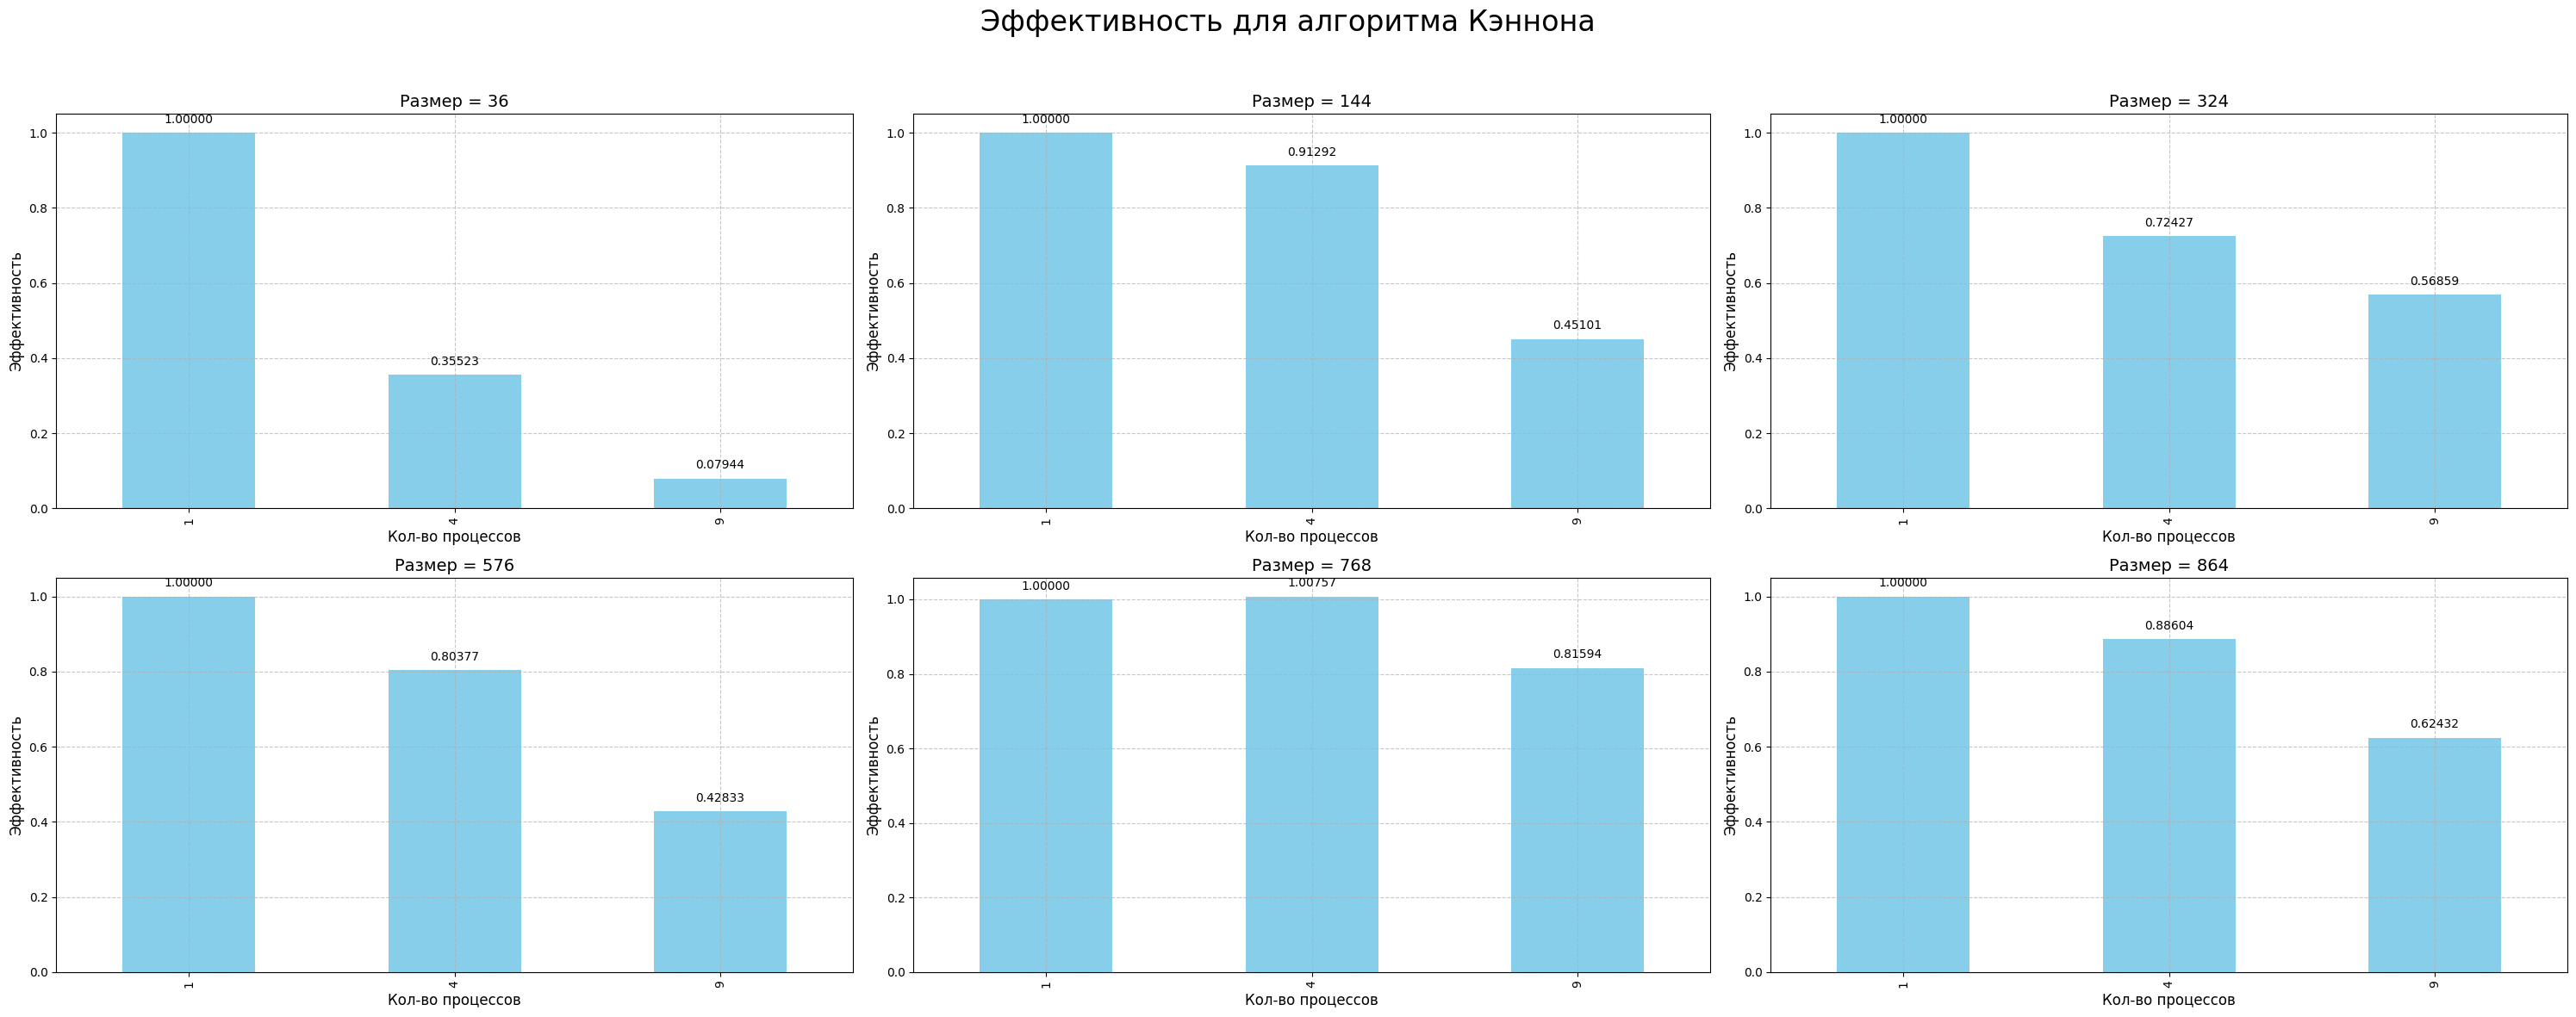

In [ ]:
num_rows = math.ceil(len(size_list) / plots_per_row)
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 10, num_rows * 6))
fig.suptitle(f'Эффективность для алгоритма Кэннона', fontsize=24)

axes = axes.flatten()

for i, size in enumerate(size_list):
    subset = results_kanon[results_kanon['Size'] == size]

    mean_efficiency = subset.groupby('Processes')['Efficiency'].mean()

    ax = axes[i]
    mean_efficiency.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'Размер = {size}', fontsize=14)
    ax.set_xlabel('Кол-во процессов', fontsize=12)
    ax.set_ylabel('Эффективность', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.5f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    xytext=(0, 6),
                    textcoords='offset points',
                    fontsize=10)

for j in range(len(size_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Зависимость эффективности от количества процессоров**

Эффективность (Efficiency = Acceleration / Number_of_Processors) характеризует, насколько рационально используются дополнительные ресурсы.

- Для N=36:
  - 4 процесса: эффективность ~0.355 (около 35%)
  - 9 процессов: эффективность ~0.079 (всего около 8%)
  
  Очень низкая эффективность при 9 процессах говорит о том, что накладные расходы доминируют.

- Для N=768:
  - 4 процесса: эффективность ~1.007 (около 100%, возможно небольшая погрешность измерений)
  - 9 процессов: эффективность ~0.816 (около 82%)
  
  Здесь эффективность более чем приемлемая. Хоть и не идеальная линейная масштабируемость, но очень высокая по сравнению с мелкими задачами.

Аналогично, для других крупных размерностей эффективность также довольно высока при увеличении числа процессов.

---

**Общие выводы:**

1. **Время vs число процессоров:**  
   Для небольших задач добавление большого числа процессов может только увеличить затраты на коммуникацию, снижая производительность. Для больших матриц рост числа процессов позволяет существенно уменьшить время выполнения.

2. **Время vs размерность матрицы:**  
   С увеличением размерности матрицы время возрастает кубически. Однако параллельная реализация помогает удерживать время выполнения на более разумном уровне, особенно при больших N.

3. **Ускорение vs число процессоров:**  
   Для мелких задач ускорение падает при чрезмерном количестве процессов. Для крупных задач ускорение значительно вырастает по мере увеличения числа процессов, практически приближаясь к хорошей масштабируемости и иногда даже превышая ожидаемые значения.

4. **Эффективность vs число процессоров:**  
   При малых задачах эффективность резко падает с ростом числа процессов. При больших задачах эффективность остаётся на высоком уровне, демонстрируя, что дополнительный параллелизм действительно приносит пользу.

Параллелизация методом Каннона для умножения матриц наиболее эффективна на больших размерностях матриц и при увеличении числа процессов. Для небольших задач добавление дополнительных ресурсов может привести к отрицательному эффекту из-за коммуникационных накладных расходов.